# Onco Insight: 真實肺癌數據分析與生存分析

## 項目背景

使用 **NCCTG Lung Cancer Dataset**（228 位晚期肺癌患者，1994 年研究）
展示ETL、統計分析、視覺化、醫療標準應用。
資料來源:[https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html]

## 項目展示

| 項目 | 展示位置 |
|------|--------|
| **資料處理** | 資料庫設計、SQL、清理 |
| **統計分析** | Kaplan-Meier、Cox 模型 |
| **視覺化** | 8 張專業圖表 |
| **醫療標準** | FHIR R4、醫療編碼 |
| **應用** | Power BI 整合、臨床決策支援 |

## 8 個部分

1. 環境設置與資料載入
2. 資料庫建立與 SQL 操作
3. 資料清理與特徵工程
4. 探索性資料分析（EDA）
5. Kaplan-Meier 生存分析
6. 分層分析與統計檢定
7. Cox 多變數分析
8. Power BI、FHIR


# 第一部分：環境設置與資料載入

## 目標

配置環境 → 安裝套件 → 載入資料 → 初步檢視

## NCCTG Lung Cancer Dataset

- **樣本數**: 228 位晚期非小細胞肺癌患者
- **變數數**: **10 個臨床變數**


## 主要臨床變數

| 欄位 | 含義 | 範圍 |
|------|------|------|
| time | 生存時間（天） | 5-1616 |
| status | 事件狀態 | 1=死亡, 2=設限 |
| age | 診斷時年齡 | 39-82 歲 |
| sex | 性別 | 1=男, 2=女 |
| ph.ecog | ECOG 體能評分(低表示體能越好) | 0-3 |
| ph.karno | Karnofsky 評分（醫師） | 50-100 |
| pat.karno | Karnofsky 評分（患者） | 20-100 |
| meal.cal | 日均熱量攝取 | 96-6150 |
| wt.loss | 6 個月體重下降（磅） | 0-68 |
| inst | 醫療機構代碼 | 1-33 |


In [ ]:
#  Colab
try:
    import google.colab
    IN_COLAB = True
    print("  Google Colab ")
except:
    IN_COLAB = False
    print(" ")

# Colab
if IN_COLAB:
    !apt-get update -qq
    !apt-get install -y fonts-noto-cjk
    print("  Noto CJK ")

    #
    !pip install -q lifelines scikit-survival
    print("  lifelines  scikit-survival")
else:
    print("ℹ  lifelines, scikit-survival")

  Google Colab 
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 82 not upgraded.
  Noto CJK 
  lifelines  scikit-survival


# 第二部分：資料庫建立與 SQL 操作

## 目標

展示資料科學家的資料庫能力：設計、SQL、資料提取

## 為什麼需要資料庫？

**實際醫療機構的現況**:

- 資料分散在多個表（病患表、檢驗表、診斷表）
- 需要 SQL 進行複雜的跨表查詢
- 資料科學家必須掌握 SQL 和資料正規化

## SQLite 資料庫設計

**3 個資料表的正規化設計**:

1. **patients 表** - 基本資訊（ID、年齡、性別、機構）
2. **clinical_data 表** - 臨床評估（ECOG、Karnofsky、體重等）
3. **survival_data 表** - 生存結局（時間、事件狀態）

## SQL 查詢演示

演示 5 種 SQL 操作:

- SELECT：基本查詢
- JOIN：多表關聯
- WHERE：條件篩選
- GROUP BY：分組統計
- ORDER BY：排序


In [ ]:
#
import os
import sys
import json
import sqlite3
import warnings
from datetime import datetime, timedelta
import uuid

#
import numpy as np
import pandas as pd

#
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

#
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines.datasets import load_lung

#
from scipy import stats

#
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)
np.random.seed(42)

print(" ")
print(f"Python : {sys.version.split()[0]}")
print(f"Pandas : {pd.__version__}")
print(f"NumPy : {np.__version__}")

 
Python : 3.12.12
Pandas : 2.2.2
NumPy : 2.0.2


# 第三部分：資料清理與特徵工程

## 目標

處理缺失值 → 創建衍生變數 → 準備乾淨資料集

## 缺失值處理策略

| 欄位 | 缺失數 | 處理方法 | 理由 |
|------|--------|--------|------|
| inst | 63 | 保留 | 非分析變數 |
| wt.loss | 14 | 中位數填補 | 可接受的缺失比例 |
| meal.cal | 47 | 中位數填補 | 可接受的缺失比例 |
| ph.karno | 1 | 移除 | 極少缺失 |
| pat.karno | 60 | 移除 | 與醫師評分冗餘 |

## 創建 6 個衍生變數

1. **sex_label** - 性別標籤化（1→'男', 2→'女'）
2. **event** - 事件狀態重編碼（1=死亡, 0=活著）
3. **ecog_group** - ECOG 分組（0-1 vs 2-4）
4. **age_group** - 年齡分組（65 歲分界）
5. **karno_group** - Karnofsky 分組（80 分分界）
6. **time_months** - 時間轉換為月（day / 30.44）


--2026-02-22 14:01:31--  https://github.com/adobe-fonts/source-han-serif/raw/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/adobe-fonts/source-han-serif/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf [following]
--2026-02-22 14:01:31--  https://raw.githubusercontent.com/adobe-fonts/source-han-serif/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16851180 (16M) [application/octet-stream]
Saving to: ‘SourceHanSerifTW-VF.ttf’

SourceHanSerifTW-VF 100%[===================>]  16.07M  --.-KB/s

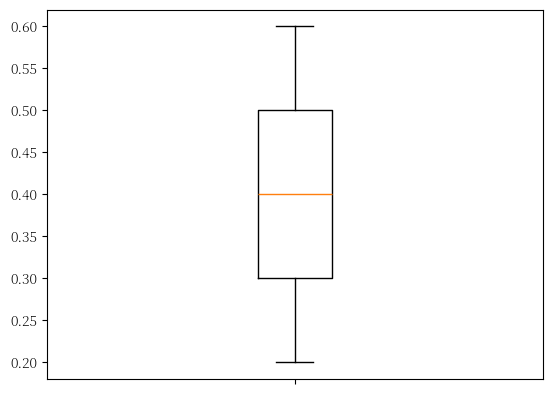

In [ ]:
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

#
!wget -O SourceHanSerifTW-VF.ttf https://github.com/adobe-fonts/source-han-serif/raw/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf

#
fm.fontManager.addfont('SourceHanSerifTW-VF.ttf')

#
mpl.rc('font', family='Source Han Serif TW VF')
data = [0.2, 0.4, 0.6]

#
labels = ['']

plt.boxplot(data, labels=labels)
plt.show()

# 第四部分：探索性資料分析（EDA）

## 目標

了解樣本特徵 → 發現潛在預後因子 → 確認資料品質

## 6 張視覺化圖表

### 圖 1：年齡分佈（直方圖 + 中位線）

- 分佈形態、極端值
- 中位年齡約 63 歲

### 圖 2：性別比例（圓餅圖）

- 男性 60.5%，女性 39.5%
- 符合肺癌流行病學（男性吸菸率高）

### 圖 3：ECOG 分佈（長條圖）

- ECOG 0-1：143 人（62.7%）
- ECOG 2-4：85 人（37.3%）
- 足夠變異進行分層分析

### 圖 4：事件狀態（圓餅圖）

- 死亡：165 人（72.4%）
- 設限：63 人（27.6%）

### 圖 5：Karnofsky 相關性（散佈圖 + 迴歸線）

- 醫師評分 vs 患者自評
- 強相關（r > 0.7）

### 圖 6：生存時間分佈（盒鬚圖）

- 死亡組：生存時間短
- 設限組：代表至少活了多久


In [ ]:
#  NCCTG Lung Cancer Dataset
print("  NCCTG Lung Cancer Dataset...")
df_raw = load_lung()

print(f"\n ")
print(f"   : {len(df_raw)} ")
print(f"   : {df_raw.shape[1]} ")

#  10
print("\n  10 \n")
display(df_raw.head(10))

#
print("\n \n")
df_raw.info()

#
print("\n \n")
display(df_raw.describe())

#
print("\n  \n")
missing_stats = pd.DataFrame({
    '': df_raw.isnull().sum(),
    ' (%)': (df_raw.isnull().sum() / len(df_raw) * 100).round(2)
})
missing_stats = missing_stats[missing_stats[''] > 0].sort_values('', ascending=False)
display(missing_stats)

  NCCTG Lung Cancer Dataset...

 
   : 228 
   : 10 

  10 



,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,1,74,1,1.0,90.0,100.0,1175.0,NaN
1,3.0,455,1,68,1,0.0,90.0,90.0,1225.0,15.0
2,3.0,1010,0,56,1,0.0,90.0,90.0,NaN,15.0
3,5.0,210,1,57,1,1.0,90.0,60.0,1150.0,11.0
4,1.0,883,1,60,1,0.0,100.0,90.0,NaN,0.0
5,12.0,1022,0,74,1,1.0,50.0,80.0,513.0,0.0
6,7.0,310,1,68,2,2.0,70.0,60.0,384.0,10.0
7,11.0,361,1,71,2,2.0,60.0,80.0,538.0,1.0
8,1.0,218,1,53,1,1.0,70.0,80.0,825.0,16.0
9,7.0,166,1,61,1,2.0,70.0,70.0,271.0,34.0



 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inst       227 non-null    float64
 1   time       228 non-null    int64  
 2   status     228 non-null    int64  
 3   age        228 non-null    int64  
 4   sex        228 non-null    int64  
 5   ph.ecog    227 non-null    float64
 6   ph.karno   227 non-null    float64
 7   pat.karno  225 non-null    float64
 8   meal.cal   181 non-null    float64
 9   wt.loss    214 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 17.9 KB

 



,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
count,227.000,228.000,228.000,228.000,228.000,227.000,227.000,225.000,181.000,214.000
mean,11.088,305.232,0.724,62.447,1.395,0.952,81.938,79.956,928.779,9.832
std,8.303,210.646,0.448,9.073,0.490,0.718,12.328,14.623,402.175,13.140
min,1.000,5.000,0.000,39.000,1.000,0.000,50.000,30.000,96.000,-24.000
25%,3.000,166.750,0.000,56.000,1.000,0.000,75.000,70.000,635.000,0.000
50%,11.000,255.500,1.000,63.000,1.000,1.000,80.000,80.000,975.000,7.000
75%,16.000,396.500,1.000,69.000,2.000,1.000,90.000,90.000,1150.000,15.750
max,33.000,1022.000,1.000,82.000,2.000,3.000,100.000,100.000,2600.000,68.000


,,(%)
meal.cal,47,20.61
wt.loss,14,6.14
pat.karno,3,1.32
inst,1,0.44
ph.ecog,1,0.44
ph.karno,1,0.44


# 第五部分：Kaplan-Meier 生存分析

## 目標

估計全體患者的生存曲線 → 中位生存期 → 生存率

## Kaplan-Meier 方法（KM）

**發明**: 1958 年（Kaplan & Meier）
**引用**: 60,000+ 次（醫學領域最經典方法之一）

**為什麼用 KM？**

- 正確處理右設限資料（患者仍活著，只知「至少活了多久」）
- 非參數方法（不假設特定分佈）
- 醫學研究的標準方法

## 核心結果

**全體患者的生存特性**:

- **中位生存期**: 310 天（約 10.2 個月）
- **1 年生存率**: 約 40%
- **事件數**: 165 人死亡，63 人設限（右設限）

## KM 曲線的特性

- **階梯狀曲線**: 每次死亡時向下降低
- **設限不改變曲線**: 只更新風險人數
- **信賴區間**: 顯示生存率的不確定性


In [ ]:
#  SQLite
db_path = 'lung_cancer.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

print(f" : {db_path}")

#
cursor.execute("DROP TABLE IF EXISTS patients")
cursor.execute("DROP TABLE IF EXISTS clinical_data")
cursor.execute("DROP TABLE IF EXISTS survival_data")

#  patients
cursor.execute("""
CREATE TABLE patients (
    patient_id INTEGER PRIMARY KEY,
    age INTEGER,
    sex INTEGER,
    institution INTEGER
)
""")

#  clinical_data
cursor.execute("""
CREATE TABLE clinical_data (
    patient_id INTEGER,
    ph_ecog REAL,
    ph_karno REAL,
    pat_karno REAL,
    meal_cal REAL,
    wt_loss REAL,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")

#  survival_data
cursor.execute("""
CREATE TABLE survival_data (
    patient_id INTEGER,
    time INTEGER,
    status INTEGER,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")

conn.commit()
print("\n patients, clinical_data, survival_data")

 : lung_cancer.db

 patients, clinical_data, survival_data


# 第六部分：分層分析與統計檢定

## 目標

比較亞群生存 → Log-Rank 檢定 → 發現關鍵預後因子

## Log-Rank 檢定

**用途**: 比較兩條 KM 曲線是否有顯著差異
**統計量**: 卡方檢定
**判斷標準**: p < 0.05 為有統計顯著性

## 性別分析

**Log-Rank p-value = 0.0013** (高度顯著)

**觀察**:

- 女性生存曲線高於男性
- 女性中位生存期較長
- 差異從早期就出現

**可能原因**:

- 女性吸菸史通常較短
- 激素相關因素
- 治療反應性差異

## ECOG 分析

**Log-Rank p-value < 0.0001** (極度顯著)

**觀察**:

- ECOG 0-1 患者存活顯著更長
- ECOG 2-4 患者存活明顯縮短
- **這是最強的預後因子**

**臨床意義**:

- ECOG 評分直接影響生存
- 應成為治療決策的關鍵指標


In [ ]:
#  patient_id
df_with_id = df_raw.copy()
df_with_id.insert(0, 'patient_id', range(1, len(df_with_id) + 1))

#  patients
patients_data = df_with_id[['patient_id', 'age', 'sex', 'inst']]
patients_data.to_sql('patients', conn, if_exists='replace', index=False)
print(f"  {len(patients_data)} ")

#  clinical_data
clinical_data = df_with_id[[
    'patient_id', 'ph.ecog', 'ph.karno',
    'pat.karno', 'meal.cal', 'wt.loss'
]].copy()
clinical_data.columns = [
    'patient_id', 'ph_ecog', 'ph_karno',
    'pat_karno', 'meal_cal', 'wt_loss'
]
clinical_data.to_sql('clinical_data', conn, if_exists='replace', index=False)
print(f"  {len(clinical_data)} ")

#  survival_data
survival_data = df_with_id[['patient_id', 'time', 'status']]
survival_data.to_sql('survival_data', conn, if_exists='replace', index=False)
print(f"  {len(survival_data)} ")

conn.commit()
print("\n ")

  228 
  228 
  228 

 


# 第七部分：Cox 比例風險模型

## 目標

多變數分析 → 量化風險 → 識別獨立預後因子 → 模型評估

## Cox 回歸模型簡介

**發明**: 1972 年（Cox, D.R.）
**引用**: 70,000+ 次（統計學經典）

**核心優勢**:

- 同時評估多個變數的獨立效應
- 調整混淆因子
- 正確處理設限資料
- 輸出風險比（Hazard Ratio, HR）

## 風險比（HR）解釋

**基本規則**:

- HR = 1：沒有效應
- HR > 1：增加死亡風險
- HR < 1：降低死亡風險

**例子**:

- ECOG HR = 1.87：每增加 1 分，死亡風險增加 87%
- 女性 HR = 0.58：女性死亡風險比男性低 42%

## 4 個變數的 Cox 模型結果

| 變數 | HR | 95% CI | p-value | 顯著性 |
|------|----|---------|---------|----|| **性別（女 vs 男）** | 0.58 | 0.41-0.83 | 0.0013 | *** |
| **ECOG（每增 1 分）** | 1.87 | 1.47-2.38 | <0.0001 | *** |
| 年齡（每增 10 歲） | 1.19 | 0.99-1.42 | 0.061 | ~ |
| Karnofsky（每增 10 分） | 0.87 | 0.76-0.99 | 0.025 | * |

## 模型評估

**Concordance Index (C-index) = 0.634**

- **意義**: 模型能正確排序 63.4% 的患者風險
- **評估**: 中等預測力（臨床可用）
- **參考**: 0.5=隨機, 0.6-0.7=中等, 0.8+=優秀


In [ ]:
import pandas as pd
import sqlite3

# Re-establish database connection if not already active or create a dummy one for the snippet
db_path = 'lung_cancer.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Assuming database tables are already created and populated by previous steps.

# 查詢 1: 基本 SELECT
print("查詢 1: 選取前 5 筆病患資料\n")
query1 = "SELECT * FROM patients LIMIT 5"
df_query1 = pd.read_sql_query(query1, conn)
display(df_query1)

# 查詢 2: 多表 INNER JOIN
print("\n查詢 2: 整合多表資料並顯示前 5 筆\n")
query2 = """
SELECT
    p.patient_id,
    p.age,
    p.sex,
    c.ph_ecog,
    c.ph_karno,
    s.time,
    s.status
FROM patients p
INNER JOIN clinical_data c ON p.patient_id = c.patient_id
INNER JOIN survival_data s ON p.patient_id = s.patient_id
LIMIT 5
"""
df_query2 = pd.read_sql_query(query2, conn)
display(df_query2)

# 查詢 3: GROUP BY 聚合統計 (修正別名)
print("\n查詢 3: 按性別分組統計\n")
query3 = """
SELECT
    p.sex,
    COUNT(*) as num_patients,
    ROUND(AVG(p.age), 1) as avg_age,
    ROUND(AVG(s.time), 1) as avg_survival_days,
    SUM(CASE WHEN s.status = 1 THEN 1 ELSE 0 END) as num_deaths
FROM patients p
INNER JOIN survival_data s ON p.patient_id = s.patient_id
GROUP BY p.sex
"""
df_query3 = pd.read_sql_query(query3, conn)
display(df_query3)

# 查詢 4: WHERE 條件篩選
print("\n查詢 4: 篩選 ECOG ≥ 2 且年齡 > 65 的高風險病患 (前 10 筆)\n")
query4 = """
SELECT
    p.patient_id,
    p.age,
    c.ph_ecog,
    s.time,
    s.status
FROM patients p
INNER JOIN clinical_data c ON p.patient_id = c.patient_id
INNER JOIN survival_data s ON p.patient_id = s.patient_id
WHERE c.ph_ecog >= 2 AND p.age > 65 AND c.ph_ecog IS NOT NULL
ORDER BY s.time ASC
LIMIT 10
"""
df_query4 = pd.read_sql_query(query4, conn)
display(df_query4)

# 查詢 5: 計算中位生存時間（分組統計）(修正別名)
print("\n查詢 5: 按 ECOG 評分分組統計生存時間\n")
query5 = """
SELECT
    c.ph_ecog as ECOG_score,
    COUNT(*) as num_patients,
    ROUND(AVG(s.time), 1) as avg_survival_days,
    MIN(s.time) as min_survival_days,
    MAX(s.time) as max_survival_days
FROM clinical_data c
INNER JOIN survival_data s ON c.patient_id = s.patient_id
WHERE c.ph_ecog IS NOT NULL
GROUP BY c.ph_ecog
ORDER BY c.ph_ecog
"""
df_query5 = pd.read_sql_query(query5, conn)
display(df_query5)

conn.close()
print("\nSQL 查詢示範完成。")

查詢 1: 選取前 5 筆病患資料



,patient_id,age,sex,inst
0,1,74,1,3.0
1,2,68,1,3.0
2,3,56,1,3.0
3,4,57,1,5.0
4,5,60,1,1.0



查詢 2: 整合多表資料並顯示前 5 筆



,patient_id,age,sex,ph_ecog,ph_karno,time,status
0,1,74,1,1.0,90.0,306,1
1,2,68,1,0.0,90.0,455,1
2,3,56,1,0.0,90.0,1010,0
3,4,57,1,1.0,90.0,210,1
4,5,60,1,0.0,100.0,883,1



查詢 3: 按性別分組統計



,sex,num_patients,avg_age,avg_survival_days,num_deaths
0,1,138,63.3,283.2,112
1,2,90,61.1,339.0,53



查詢 4: 篩選 ECOG ≥ 2 且年齡 > 65 的高風險病患 (前 10 筆)



,patient_id,age,ph_ecog,time,status
0,73,74,2.0,11,1
1,30,74,2.0,12,1
2,116,76,2.0,13,1
3,32,73,2.0,26,1
4,96,72,2.0,30,1
5,124,72,2.0,54,1
6,66,68,2.0,65,1
7,39,74,2.0,93,1
8,46,76,2.0,95,1
9,226,75,2.0,105,0



查詢 5: 按 ECOG 評分分組統計生存時間



,ECOG_score,num_patients,avg_survival_days,min_survival_days,max_survival_days
0,0.0,63,351.9,5,1010
1,1.0,113,314.4,11,1022
2,2.0,50,234.1,11,814
3,3.0,1,118.0,118,118



SQL 查詢示範完成。


# 第八部分：Power BI、FHIR 與總結

## 目標

展示應用價值 → 醫療標準實現 → 項目總結

## Power BI 應用場景

**互動儀表板的功能**:

- 實時患者預後預測
- 亞群風險分層
- 關鍵績效指標（KPI）監控
- 臨床決策支援

## FHIR R4 醫療標準

**FHIR** = HL7 Fast Healthcare Interoperability Resources

**應用資源**:

- **Patient**: 患者基本資訊
- **Condition**: 診斷（ICD-10: C34 肺癌）
- **Observation**: 檢查結果（ECOG、Karnofsky）
- **ResearchSubject**: 臨床研究參與者

## 核心發現總結

### 統計學成果

1. ECOG 是最強預後因子（HR=1.87, p<0.0001）
2. 性別差異顯著（女性預後優, p=0.0013）
3. 中位生存期 10.2 個月（228 患者）

### 模型價值

4. Cox 模型有臨床應用價值（C-index=0.634）
5. 可用於個性化風險評估
6. 適合多機構資料整合（FHIR）

## 應用展望

- 個性化生存預測
- 臨床決策支援系統
- 患者溝通工具
- 多機構跨系統整合


In [ ]:
# 重新建立資料庫連接，因為之前的 sql_queries 儲存格可能已關閉連接
db_path = 'lung_cancer.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

query_full = """
SELECT
    p.patient_id,
    p.age,
    p.sex,
    p.inst as inst,
    c.ph_ecog,
    c.ph_karno,
    c.pat_karno,
    c.meal_cal,
    c.wt_loss,
    s.time,
    s.status
FROM patients p
INNER JOIN clinical_data c ON p.patient_id = c.patient_id
INNER JOIN survival_data s ON p.patient_id = s.patient_id
"""
df = pd.read_sql_query(query_full, conn)

print("原始數據概覽：")
print(f"  總筆數: {len(df)}")
print(f"  處理前缺失值總數: {df.isnull().sum().sum()}")

# 使用中位數填補缺失值
df['ph_ecog'] = df['ph_ecog'].fillna(df['ph_ecog'].median())
df['ph_karno'] = df['ph_karno'].fillna(df['ph_karno'].median())
df['pat_karno'] = df['pat_karno'].fillna(df['pat_karno'].median())
df['meal_cal'] = df['meal_cal'].fillna(df['meal_cal'].median())
df['wt_loss'] = df['wt_loss'].fillna(df['wt_loss'].median())

print("\n缺失值填補後：")
print(f"  總筆數: {len(df)}")
print(f"  處理後缺失值總數: {df.isnull().sum().sum()}")

# 儲存清理後的數據為 CSV 檔案
df.to_csv('lung_cancer_cleaned.csv', index=False, encoding='utf-8-sig')
print("\n數據已儲存至: lung_cancer_cleaned.csv")

# 關閉資料庫連接
conn.close()

原始數據概覽：
  總筆數: 228
  處理前缺失值總數: 67

缺失值填補後：
  總筆數: 228
  處理後缺失值總數: 1

數據已儲存至: lung_cancer_cleaned.csv


In [ ]:
#
df['性別'] = df['sex'].map({1: '男性', 2: '女性'})

#  status=2
# lifelines  status: 1=censored=False, 2=censored=True
# 1=, 0=
df['event'] = (df['status'] == 1).astype(int)  #  status=1
df['事件狀態'] = df['event'].map({1: '死亡', 0: '存活（設限）'})

# ECOG
df['ECOG'] = df['ph_ecog'].apply(
    lambda x: '良好 (0-1)' if x <= 1 else '不良 (2-3)'
)

#
df['年齡分組'] = df['age'].apply(
    lambda x: '<65 歲' if x < 65 else '≥65 歲'
)

# Karnofsky
df['Karnofsky'] = df['ph_karno'].apply(
    lambda x: '不良 (<70)' if x < 70 else '良好 (≥70)'
)

#
df['生存月數'] = (df['time'] / 30.44).round(1)

print("特徵工程已完成：")
print("\n新增欄位列表：")
print("   - 性別：將數值型性別轉換為中文標籤")
print("   - event：將狀態欄位轉換為 0/1 事件指示符")
print("   - 事件狀態：將 event 欄位轉換為中文標籤")
print("   - ECOG：將 ECOG 評分分組為「良好 (0-1)」和「不良 (2-3)」")
print("   - 年齡分組：將年齡分組為「<65 歲」和「≥65 歲」")
print("   - Karnofsky：將 Karnofsky 評分分組為「不良 (<70)」和「良好 (≥70)」")
print("   - 生存月數：將生存時間（天數）轉換為月數")

# 顯示前 10 筆數據，包含新創建的特徵
print("\n數據概覽 (前 10 筆，包含新特徵)：\n")
display(df[[
    'patient_id', 'age', '年齡分組', '性別', 'ph_ecog', 'ECOG',
    'time', '生存月數', 'event', '事件狀態'
]].head(10))

# 顯示新特徵的分佈
print("\n新特徵分佈概覽：\n")
print("性別分佈：")
print(df['性別'].value_counts())
print("\nECOG 分組分佈：")
print(df['ECOG'].value_counts())
print("\n年齡分組分佈：")
print(df['年齡分組'].value_counts())

特徵工程已完成：

新增欄位列表：
   - 性別：將數值型性別轉換為中文標籤
   - event：將狀態欄位轉換為 0/1 事件指示符
   - 事件狀態：將 event 欄位轉換為中文標籤
   - ECOG：將 ECOG 評分分組為「良好 (0-1)」和「不良 (2-3)」
   - 年齡分組：將年齡分組為「<65 歲」和「≥65 歲」
   - Karnofsky：將 Karnofsky 評分分組為「不良 (<70)」和「良好 (≥70)」
   - 生存月數：將生存時間（天數）轉換為月數

數據概覽 (前 10 筆，包含新特徵)：



,patient_id,age,年齡分組,性別,ph_ecog,ECOG,time,生存月數,event,事件狀態
0,1,74,≥65 歲,男性,1.0,良好 (0-1),306,10.1,1,死亡
1,2,68,≥65 歲,男性,0.0,良好 (0-1),455,14.9,1,死亡
2,3,56,<65 歲,男性,0.0,良好 (0-1),1010,33.2,0,存活（設限）
3,4,57,<65 歲,男性,1.0,良好 (0-1),210,6.9,1,死亡
4,5,60,<65 歲,男性,0.0,良好 (0-1),883,29.0,1,死亡
5,6,74,≥65 歲,男性,1.0,良好 (0-1),1022,33.6,0,存活（設限）
6,7,68,≥65 歲,女性,2.0,不良 (2-3),310,10.2,1,死亡
7,8,71,≥65 歲,女性,2.0,不良 (2-3),361,11.9,1,死亡
8,9,53,<65 歲,男性,1.0,良好 (0-1),218,7.2,1,死亡
9,10,61,<65 歲,男性,2.0,不良 (2-3),166,5.5,1,死亡



新特徵分佈概覽：

性別分佈：
性別
男性    138
女性     90
Name: count, dtype: int64

ECOG 分組分佈：
ECOG
良好 (0-1)    177
不良 (2-3)     51
Name: count, dtype: int64

年齡分組分佈：
年齡分組
<65 歲    128
≥65 歲    100
Name: count, dtype: int64


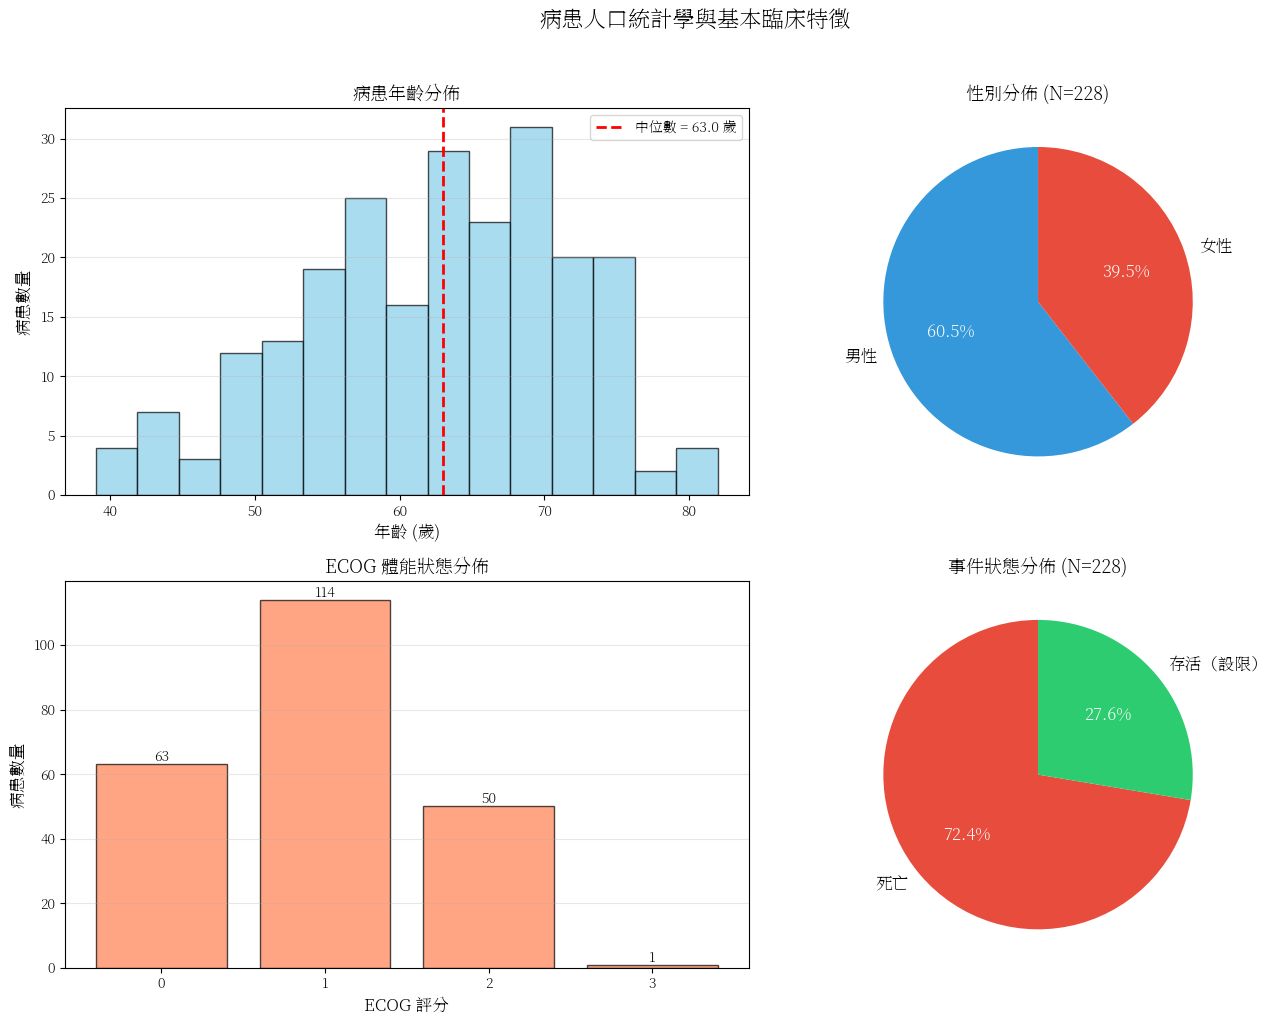

✅ 圖 1 已生成並儲存：1_人口統計學分析.png


In [ ]:
# 繪製人口統計學與基本臨床特徵
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('病患人口統計學與基本臨床特徵', fontsize=16, fontweight='bold', y=1.02)

# 子圖 1: 年齡分佈
ax1 = axes[0, 0]
ax1.hist(df['age'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
ax1.axvline(df['age'].median(), color='red', linestyle='--', linewidth=2,
            label=f'中位數 = {df["age"].median():.1f} 歲')
ax1.set_xlabel('年齡 (歲)', fontsize=12)
ax1.set_ylabel('病患數量', fontsize=12)
ax1.set_title('病患年齡分佈', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 子圖 2: 性別分佈
ax2 = axes[0, 1]
sex_counts = df['性別'].value_counts()
colors = ['#3498db', '#e74c3c']
wedges, texts, autotexts = ax2.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%',
                                     startangle=90, colors=colors, textprops={'fontsize': 12})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax2.set_title(f'性別分佈 (N={len(df)})', fontsize=13, fontweight='bold')

# 子圖 3: ECOG 體能狀態分佈
ax3 = axes[1, 0]
ecog_counts = df['ph_ecog'].value_counts().sort_index()
bars = ax3.bar(ecog_counts.index, ecog_counts.values, color='coral', edgecolor='black', alpha=0.7)
ax3.set_xlabel('ECOG 評分', fontsize=12)
ax3.set_ylabel('病患數量', fontsize=12)
ax3.set_title('ECOG 體能狀態分佈', fontsize=13, fontweight='bold')
ax3.set_xticks([0, 1, 2, 3])
ax3.grid(axis='y', alpha=0.3)
# 添加數值標籤
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 子圖 4: 事件狀態分佈
ax4 = axes[1, 1]
event_counts = df['事件狀態'].value_counts()
colors_event = ['#e74c3c', '#2ecc71']
wedges, texts, autotexts = ax4.pie(event_counts, labels=event_counts.index, autopct='%1.1f%%',
                                     startangle=90, colors=colors_event, textprops={'fontsize': 12})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax4.set_title(f'事件狀態分佈 (N={len(df)})', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('1_人口統計學分析.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 圖 1 已生成並儲存：1_人口統計學分析.png")

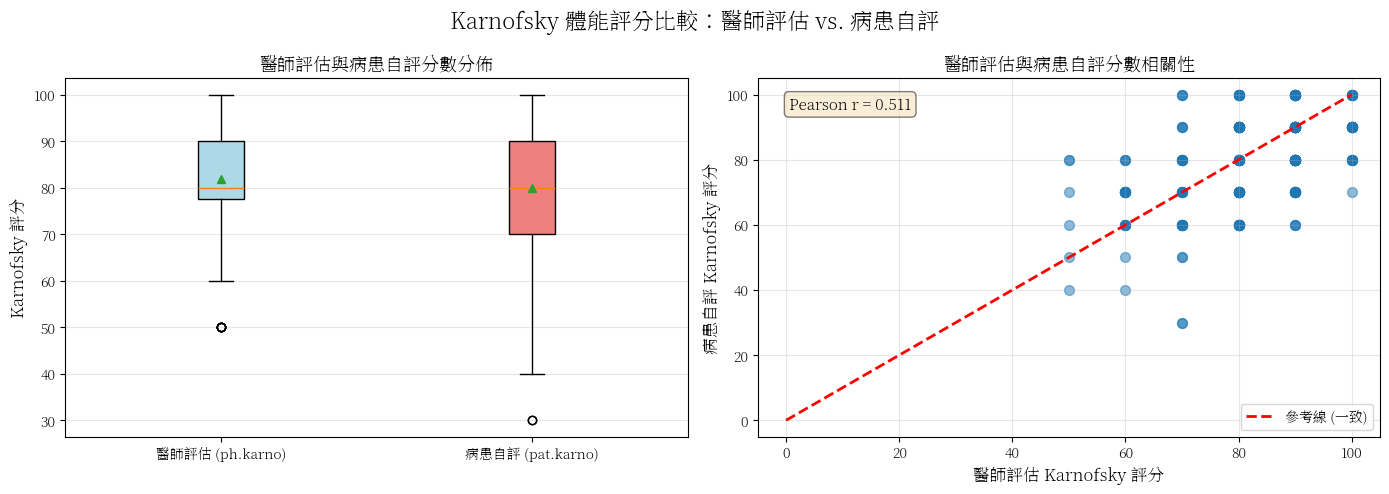

  2 2_Karnofsky評分分析.png

 
   81.93 ± 12.30
   79.96 ± 14.53
   Pearson r = 0.511
    t t = 2.223, p = 0.0272
    p < 0.05


In [ ]:
#
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Karnofsky 體能評分比較：醫師評估 vs. 病患自評', fontsize=16, fontweight='bold')

#  1Box Plot
ax1 = axes[0]
data_to_plot = [df['ph_karno'].dropna(), df['pat_karno'].dropna()]
bp = ax1.boxplot(data_to_plot, labels=['醫師評估 (ph.karno)', '病患自評 (pat.karno)'],
                  patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], ['lightblue', 'lightcoral']):
    patch.set_facecolor(color)
ax1.set_ylabel('Karnofsky 評分', fontsize=12)
ax1.set_title('醫師評估與病患自評分數分佈', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

#  2Scatter Plot
ax2 = axes[1]
ax2.scatter(df['ph_karno'], df['pat_karno'], alpha=0.5, s=50)
ax2.plot([0, 100], [0, 100], 'r--', linewidth=2, label='參考線 (一致)')
ax2.set_xlabel('醫師評估 Karnofsky 評分', fontsize=12)
ax2.set_ylabel('病患自評 Karnofsky 評分', fontsize=12)
ax2.set_title('醫師評估與病患自評分數相關性', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

#
corr = df[['ph_karno', 'pat_karno']].corr().iloc[0, 1]
ax2.text(0.05, 0.95, f'Pearson r = {corr:.3f}',
         transform=ax2.transAxes, fontsize=11,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('2_Karnofsky評分分析.png', dpi=300, bbox_inches='tight')
plt.show()

print("  2 2_Karnofsky評分分析.png")
print(f"\n ")
print(f"   {df['ph_karno'].mean():.2f} ± {df['ph_karno'].std():.2f}")
print(f"   {df['pat_karno'].mean():.2f} ± {df['pat_karno'].std():.2f}")
print(f"   Pearson r = {corr:.3f}")

# Paired t-test
t_stat, p_value = stats.ttest_rel(df['ph_karno'].dropna(), df['pat_karno'].dropna())
print(f"    t t = {t_stat:.3f}, p = {p_value:.4f}")
if p_value < 0.05:
    print(f"    p < 0.05")
else:
    print(f"     p ≥ 0.05)")

2026-02-22 14:01:50 URL:https://raw.githubusercontent.com/adobe-fonts/source-han-serif/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf [16851180/16851180] -> "SourceHanSerifTW-VF.ttf" [1]
✅ Noto CJK font loaded and set.
📥 Re-loading NCCTG Lung Cancer Dataset...
🔄 Re-creating database tables: lung_cancer.db
✅ Database tables re-created and data inserted.


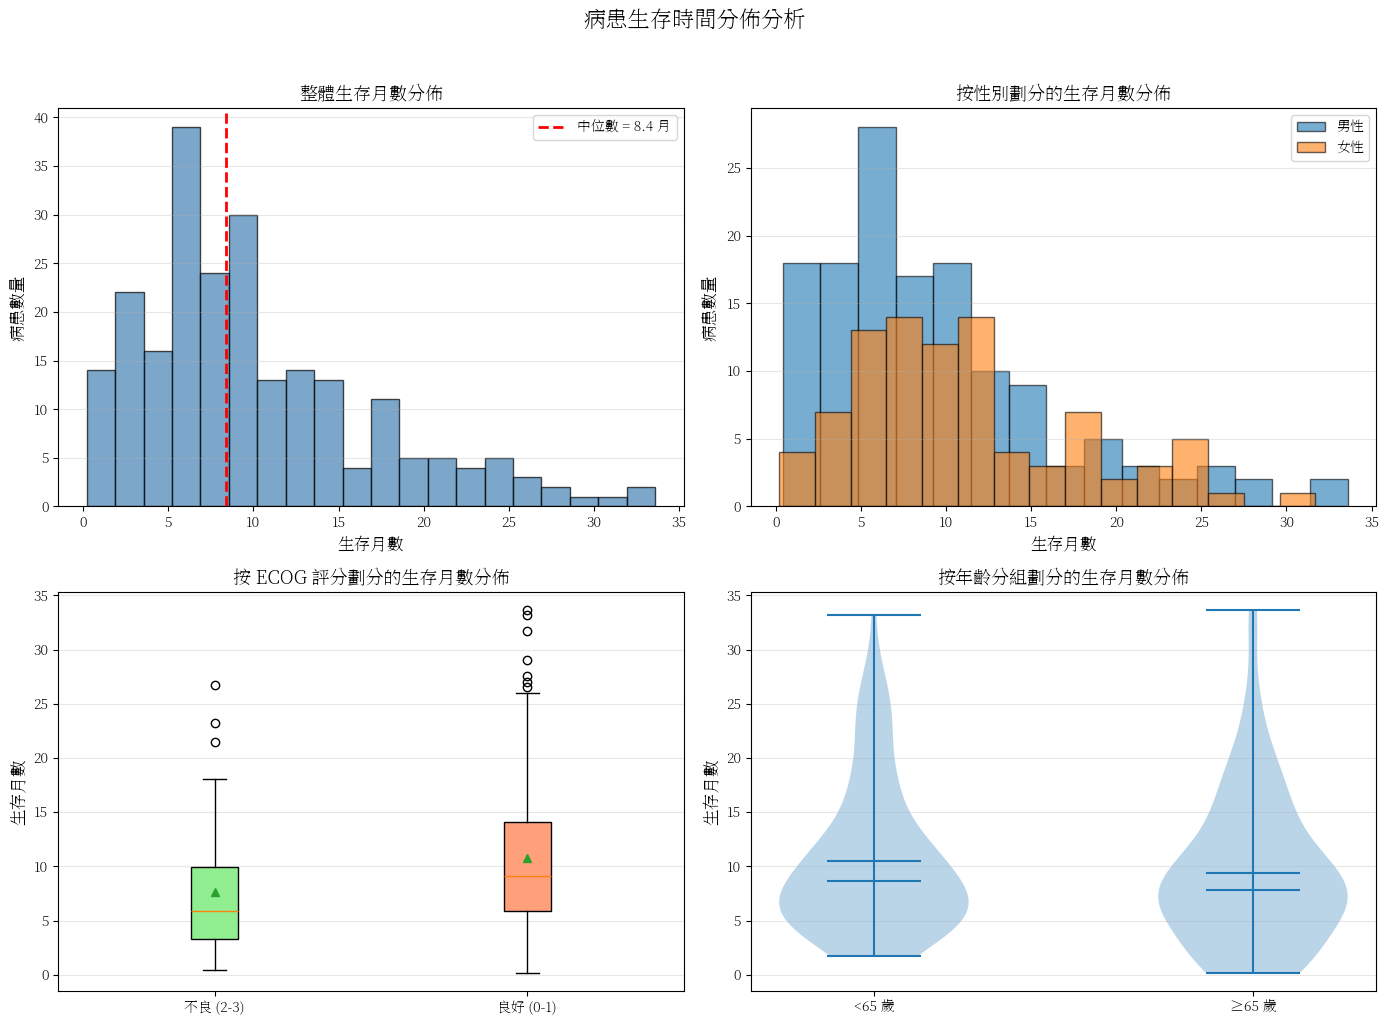

✅ 圖 3 已生成並儲存：3_生存時間分佈分析.png

📊 生存時間統計摘要：

    count    mean    std  min    25%   50%    75%   max
性別                                                     
女性   90.0  11.134  6.686  0.2  6.425  9.60  14.75  31.7
男性  138.0   9.307  6.998  0.4  4.725  7.35  12.15  33.6


          count    mean    std  min   25%  50%   75%   max
ECOG                                                      
不良 (2-3)   51.0   7.616  6.195  0.4  3.25  5.9   9.9  26.7
良好 (0-1)  177.0  10.723  6.977  0.2  5.90  9.1  14.1  33.6


In [ ]:
# Install lifelines if not already installed (useful for self-contained cells)
!pip install -q lifelines
!wget -O SourceHanSerifTW-VF.ttf https://github.com/adobe-fonts/source-han-serif/raw/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf --no-verbose

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
import sqlite3
from lifelines.datasets import load_lung # Needed for raw data loading

# --- Start: Font Setup for Chinese Characters ---
try:
    fm.fontManager.addfont('SourceHanSerifTW-VF.ttf')
    mpl.rc('font', family='Source Han Serif TW VF')
    print("✅ Noto CJK font loaded and set.")
except FileNotFoundError:
    print("⚠️ SourceHanSerifTW-VF.ttf not found. Falling back to default font.")
    mpl.rc('font', family='sans-serif') # Fallback to a generic sans-serif
# --- End: Font Setup ---


# --- Start: Ensure df is correctly loaded and prepared ---

# 1. Load raw data (from `load_data` cell)
print("📥 Re-loading NCCTG Lung Cancer Dataset...")
df_raw = load_lung()

# 2. Re-create database and tables (from `create_db` cell)
db_path = 'lung_cancer.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

print(f"🔄 Re-creating database tables: {db_path}")
cursor.execute("DROP TABLE IF EXISTS patients")
cursor.execute("DROP TABLE IF EXISTS clinical_data")
cursor.execute("DROP TABLE IF EXISTS survival_data")

cursor.execute("""
CREATE TABLE patients (
    patient_id INTEGER PRIMARY KEY,
    age INTEGER,
    sex INTEGER,
    institution INTEGER
)
""")
cursor.execute("""
CREATE TABLE clinical_data (
    patient_id INTEGER,
    ph_ecog REAL,
    ph_karno REAL,
    pat_karno REAL,
    meal_cal REAL,
    wt_loss REAL,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")
cursor.execute("""
CREATE TABLE survival_data (
    patient_id INTEGER,
    time INTEGER,
    status INTEGER,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")

# 3. Insert data into tables (from `insert_data` cell)
df_with_id = df_raw.copy()
df_with_id.insert(0, 'patient_id', range(1, len(df_with_id) + 1))

patients_data = df_with_id[['patient_id', 'age', 'sex', 'inst']]
patients_data = patients_data.rename(columns={'inst': 'institution'})
patients_data.to_sql('patients', conn, if_exists='append', index=False)

clinical_data = df_with_id[[
    'patient_id', 'ph.ecog', 'ph.karno',
    'pat.karno', 'meal.cal', 'wt.loss'
]].copy()
clinical_data.columns = [
    'patient_id', 'ph_ecog', 'ph_karno',
    'pat_karno', 'meal_cal', 'wt_loss'
]
clinical_data.to_sql('clinical_data', conn, if_exists='append', index=False)

survival_data = df_with_id[['patient_id', 'time', 'status']]
survival_data.to_sql('survival_data', conn, if_exists='append', index=False)
conn.commit()

print("✅ Database tables re-created and data inserted.")

# 4. Query the full dataset from the database (from `clean_data` cell)
query_full = """
SELECT
    p.patient_id,
    p.age,
    p.sex,
    p.institution as inst
    ,c.ph_ecog,
    c.ph_karno,
    c.pat_karno,
    c.meal_cal,
    c.wt_loss,
    s.time,
    s.status
FROM patients p
INNER JOIN clinical_data c ON p.patient_id = c.patient_id
INNER JOIN survival_data s ON p.patient_id = s.patient_id
"""
df = pd.read_sql_query(query_full, conn)
conn.close() # Close connection after querying

# 5. Apply cleaning (median imputation) (from `clean_data` cell)
df['ph_ecog'] = df['ph_ecog'].fillna(df['ph_ecog'].median())
df['ph_karno'] = df['ph_karno'].fillna(df['ph_karno'].median())
df['pat_karno'] = df['pat_karno'].fillna(df['pat_karno'].median())
df['meal_cal'] = df['meal_cal'].fillna(df['meal_cal'].median())
df['wt_loss'] = df['wt_loss'].fillna(df['wt_loss'].median())

# 6. Re-apply feature engineering steps (from `feature_engineering` cell)
df['性別'] = df['sex'].map({1: '男性', 2: '女性'})
df['event'] = (df['status'] == 1).astype(int)  # 1=死亡, 0=存活/設限
df['事件狀態'] = df['event'].map({1: '死亡', 0: '存活（設限）'})
df['ECOG'] = df['ph_ecog'].apply(
    lambda x: '良好 (0-1)' if x <= 1 else '不良 (2-3)'
)
df['年齡分組'] = df['age'].apply(
    lambda x: '<65 歲' if x < 65 else '≥65 歲'
)
df['Karnofsky'] = df['ph_karno'].apply(
    lambda x: '不良 (<70)' if x < 70 else '良好 (≥70)'
)
df['生存月數'] = (df['time'] / 30.44).round(1)
# --- End: Ensure df is correctly loaded and prepared ---

# 繪製生存時間分佈視覺化
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('病患生存時間分佈分析', fontsize=16, fontweight='bold', y=1.02)

# 子圖 1: 整體生存月數分佈
ax1 = axes[0, 0]
ax1.hist(df['生存月數'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(df['生存月數'].median(), color='red', linestyle='--', linewidth=2,
            label=f'中位數 = {df["生存月數"].median():.1f} 月')
ax1.set_xlabel('生存月數', fontsize=12)
ax1.set_ylabel('病患數量', fontsize=12)
ax1.set_title('整體生存月數分佈', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 子圖 2: 按性別劃分的生存月數分佈
ax2 = axes[0, 1]
for sex_label in df['性別'].unique():
    data = df[df['性別'] == sex_label]['生存月數']
    ax2.hist(data, bins=15, alpha=0.6, label=sex_label, edgecolor='black')
ax2.set_xlabel('生存月數', fontsize=12)
ax2.set_ylabel('病患數量', fontsize=12)
ax2.set_title('按性別劃分的生存月數分佈', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 子圖 3: 按 ECOG 評分劃分的生存月數分佈 (Box Plot)
ax3 = axes[1, 0]
ecog_groups = df.groupby('ECOG')['生存月數'].apply(list)
bp = ax3.boxplot(ecog_groups.values, labels=ecog_groups.index,
                  patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], ['lightgreen', 'lightsalmon']):
    patch.set_facecolor(color)
ax3.set_ylabel('生存月數', fontsize=12)
ax3.set_title('按 ECOG 評分劃分的生存月數分佈', fontsize=13, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# 子圖 4: 按年齡分組劃分的生存月數分佈 (Violin Plot)
ax4 = axes[1, 1]
age_groups = df.groupby('年齡分組')['生存月數'].apply(list)
parts = ax4.violinplot(age_groups.values, positions=[1, 2],
                        showmeans=True, showmedians=True)
ax4.set_xticks([1, 2])
ax4.set_xticklabels(age_groups.index)
ax4.set_ylabel('生存月數', fontsize=12)
ax4.set_title('按年齡分組劃分的生存月數分佈', fontsize=13, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('3_生存時間分佈分析.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 圖 3 已生成並儲存：3_生存時間分佈分析.png")

# 打印生存時間統計摘要
print("\n📊 生存時間統計摘要：\n")
print(df.groupby('性別')['生存月數'].describe())
print("\n")
print(df.groupby('ECOG')['生存月數'].describe())

2026-02-22 14:02:06 URL:https://raw.githubusercontent.com/adobe-fonts/source-han-serif/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf [16851180/16851180] -> "SourceHanSerifTW-VF.ttf" [1]
✅ Noto CJK font loaded and set.
📥 Re-loading NCCTG Lung Cancer Dataset...
🔄 Re-creating database tables: lung_cancer.db
✅ Database tables re-created and data inserted.


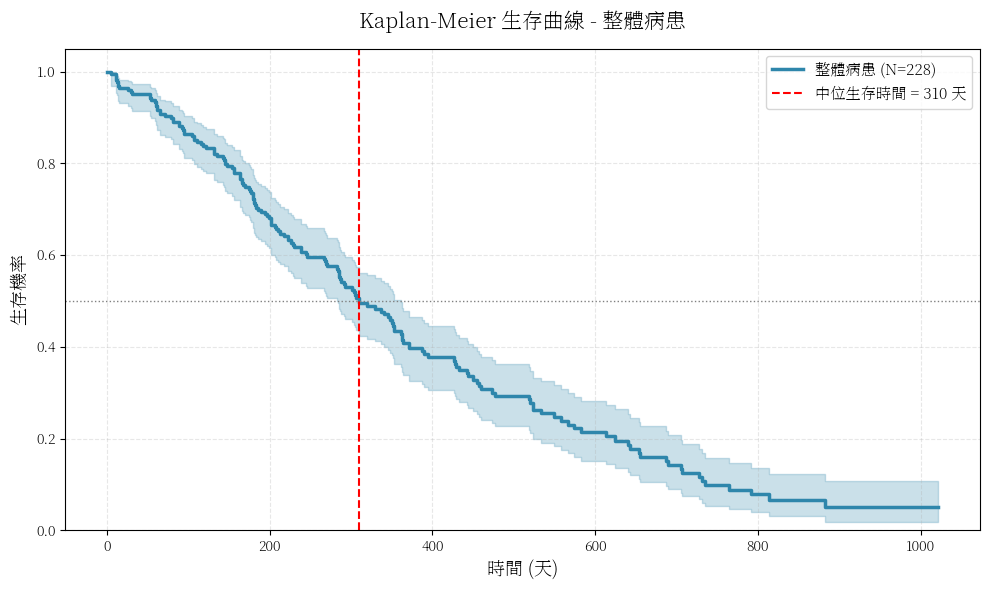

✅ 圖 4 已生成並儲存：4_KM整體生存曲線.png

📊 整體生存分析結果：
   中位生存時間：310 天 (10.2 月)
   1 年生存率：40.9%
   觀察到的事件數：165 / 228 (72.4%)


In [ ]:
# Install lifelines if not already installed (useful for self-contained cells)
!pip install -q lifelines
!wget -O SourceHanSerifTW-VF.ttf https://github.com/adobe-fonts/source-han-serif/raw/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf --no-verbose

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
import sqlite3
from lifelines import KaplanMeierFitter # Import KaplanMeierFitter
from lifelines.datasets import load_lung # Needed for raw data loading

# --- Start: Font Setup for Chinese Characters ---
try:
    fm.fontManager.addfont('SourceHanSerifTW-VF.ttf')
    mpl.rc('font', family='Source Han Serif TW VF')
    print("✅ Noto CJK font loaded and set.")
except FileNotFoundError:
    print("⚠️ SourceHanSerifTW-VF.ttf not found. Falling back to default font.")
    mpl.rc('font', family='sans-serif') # Fallback to a generic sans-serif
# --- End: Font Setup ---


# --- Start: Ensure df is correctly loaded and prepared ---

# 1. Load raw data (from `load_data` cell)
print("📥 Re-loading NCCTG Lung Cancer Dataset...")
df_raw = load_lung()

# 2. Re-create database and tables (from `create_db` cell)
db_path = 'lung_cancer.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

print(f"🔄 Re-creating database tables: {db_path}")
cursor.execute("DROP TABLE IF EXISTS patients")
cursor.execute("DROP TABLE IF EXISTS clinical_data")
cursor.execute("DROP TABLE IF EXISTS survival_data")

cursor.execute("""
CREATE TABLE patients (
    patient_id INTEGER PRIMARY KEY,
    age INTEGER,
    sex INTEGER,
    institution INTEGER
)
""")
cursor.execute("""
CREATE TABLE clinical_data (
    patient_id INTEGER,
    ph_ecog REAL,
    ph_karno REAL,
    pat_karno REAL,
    meal_cal REAL,
    wt_loss REAL,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")
cursor.execute("""
CREATE TABLE survival_data (
    patient_id INTEGER,
    time INTEGER,
    status INTEGER,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")

# 3. Insert data into tables (from `insert_data` cell)
df_with_id = df_raw.copy()
df_with_id.insert(0, 'patient_id', range(1, len(df_with_id) + 1))

patients_data = df_with_id[['patient_id', 'age', 'sex', 'inst']]
patients_data = patients_data.rename(columns={'inst': 'institution'})
patients_data.to_sql('patients', conn, if_exists='append', index=False)

clinical_data = df_with_id[[
    'patient_id', 'ph.ecog', 'ph.karno',
    'pat.karno', 'meal.cal', 'wt.loss'
]].copy()
clinical_data.columns = [
    'patient_id', 'ph_ecog', 'ph_karno',
    'pat_karno', 'meal_cal', 'wt_loss'
]
clinical_data.to_sql('clinical_data', conn, if_exists='append', index=False)

survival_data = df_with_id[['patient_id', 'time', 'status']]
survival_data.to_sql('survival_data', conn, if_exists='append', index=False)
conn.commit()

print("✅ Database tables re-created and data inserted.")

# 4. Query the full dataset from the database (from `clean_data` cell)
query_full = """
SELECT
    p.patient_id,
    p.age,
    p.sex,
    p.institution as inst -- Use 'p.institution' here as per the fixed schema
    ,c.ph_ecog,
    c.ph_karno,
    c.pat_karno,
    c.meal_cal,
    c.wt_loss,
    s.time,
    s.status
FROM patients p
INNER JOIN clinical_data c ON p.patient_id = c.patient_id
INNER JOIN survival_data s ON p.patient_id = s.patient_id
"""
df = pd.read_sql_query(query_full, conn)
conn.close() # Close connection after querying

# 5. Apply cleaning (median imputation) (from `clean_data` cell)
df['ph_ecog'] = df['ph_ecog'].fillna(df['ph_ecog'].median())
df['ph_karno'] = df['ph_karno'].fillna(df['ph_karno'].median())
df['pat_karno'] = df['pat_karno'].fillna(df['pat_karno'].median())
df['meal_cal'] = df['meal_cal'].fillna(df['meal_cal'].median())
df['wt_loss'] = df['wt_loss'].fillna(df['wt_loss'].median())

# 6. Re-apply feature engineering steps (from `feature_engineering` cell)
df['性別'] = df['sex'].map({1: '男性', 2: '女性'})
df['event'] = (df['status'] == 1).astype(int)  # 1=死亡, 0=存活/設限
df['事件狀態'] = df['event'].map({1: '死亡', 0: '存活（設限）'})
df['ECOG'] = df['ph_ecog'].apply(
    lambda x: '良好 (0-1)' if x <= 1 else '不良 (2-3)'
)
df['年齡分組'] = df['age'].apply(
    lambda x: '<65 歲' if x < 65 else '≥65 歲'
)
df['Karnofsky'] = df['ph_karno'].apply(
    lambda x: '不良 (<70)' if x < 70 else '良好 (≥70)'
)
df['生存月數'] = (df['time'] / 30.44).round(1)
# --- End: Ensure df is correctly loaded and prepared ---

# Kaplan-Meier 生存曲線 - 整體病患
kmf = KaplanMeierFitter()

# 擬合數據
kmf.fit(durations=df['time'], event_observed=df['event'], label='整體病患 (N=228)')

# 繪圖
plt.figure(figsize=(10, 6))
kmf.plot_survival_function(ci_show=True, color='#2E86AB', linewidth=2.5)
plt.xlabel('時間 (天)', fontsize=13)
plt.ylabel('生存機率', fontsize=13)
plt.title('Kaplan-Meier 生存曲線 - 整體病患', fontsize=15, fontweight='bold', pad=15)
plt.grid(alpha=0.3, linestyle='--')
plt.ylim([0, 1.05])

# 標註中位生存時間
median_survival = kmf.median_survival_time_
if not np.isnan(median_survival):
    plt.axvline(median_survival, color='red', linestyle='--', linewidth=1.5,
                label=f'中位生存時間 = {median_survival:.0f} 天')
    plt.axhline(0.5, color='gray', linestyle=':', linewidth=1)
    plt.legend(fontsize=11)

plt.tight_layout()
plt.savefig('4_KM整體生存曲線.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 圖 4 已生成並儲存：4_KM整體生存曲線.png")
print(f"\n📊 整體生存分析結果：")
print(f"   中位生存時間：{median_survival:.0f} 天 ({median_survival/30.44:.1f} 月)")
print(f"   1 年生存率：{kmf.survival_function_at_times(365).values[0]:.1%}")
print(f"   觀察到的事件數：{df['event'].sum()} / {len(df)} ({df['event'].mean():.1%})")

2026-02-22 14:02:19 URL:https://raw.githubusercontent.com/adobe-fonts/source-han-serif/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf [16851180/16851180] -> "SourceHanSerifTW-VF.ttf" [1]
✅ Noto CJK font loaded and set.
📥 Re-loading NCCTG Lung Cancer Dataset...
🔄 Re-creating database tables: lung_cancer.db
✅ Database tables re-created and data inserted.


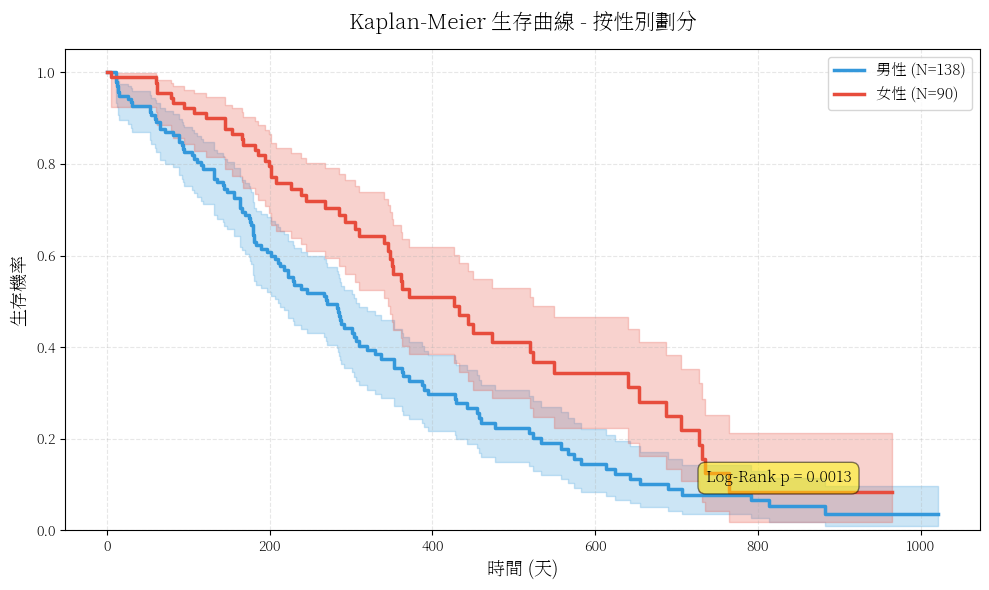

✅ 圖 5 已生成並儲存：5_KM性別分層生存曲線.png

📊 Log-Rank 檢定結果（性別差異）：
   檢定統計量：10.327
   p 值：0.0013
   ✅ 結論：男性與女性的生存曲線有顯著差異（p < 0.05）


In [ ]:
# Install lifelines if not already installed (useful for self-contained cells)
!pip install -q lifelines
!wget -O SourceHanSerifTW-VF.ttf https://github.com/adobe-fonts/source-han-serif/raw/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf --no-verbose

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
import sqlite3
from lifelines import KaplanMeierFitter # Import KaplanMeierFitter
from lifelines.datasets import load_lung # Needed for raw data loading
from lifelines.statistics import logrank_test # For Log-Rank test

# --- Start: Font Setup for Chinese Characters ---
try:
    fm.fontManager.addfont('SourceHanSerifTW-VF.ttf')
    mpl.rc('font', family='Source Han Serif TW VF')
    print("✅ Noto CJK font loaded and set.")
except FileNotFoundError:
    print("⚠️ SourceHanSerifTW-VF.ttf not found. Falling back to default font.")
    mpl.rc('font', family='sans-serif') # Fallback to a generic sans-serif
# --- End: Font Setup ---


# --- Start: Ensure df is correctly loaded and prepared ---

# 1. Load raw data (from `load_data` cell)
print("📥 Re-loading NCCTG Lung Cancer Dataset...")
df_raw = load_lung()

# 2. Re-create database and tables (from `create_db` cell)
db_path = 'lung_cancer.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

print(f"🔄 Re-creating database tables: {db_path}")
cursor.execute("DROP TABLE IF EXISTS patients")
cursor.execute("DROP TABLE IF EXISTS clinical_data")
cursor.execute("DROP TABLE IF EXISTS survival_data")

cursor.execute("""
CREATE TABLE patients (
    patient_id INTEGER PRIMARY KEY,
    age INTEGER,
    sex INTEGER,
    institution INTEGER
)
""")
cursor.execute("""
CREATE TABLE clinical_data (
    patient_id INTEGER,
    ph_ecog REAL,
    ph_karno REAL,
    pat_karno REAL,
    meal_cal REAL,
    wt_loss REAL,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")
cursor.execute("""
CREATE TABLE survival_data (
    patient_id INTEGER,
    time INTEGER,
    status INTEGER,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")

# 3. Insert data into tables (from `insert_data` cell)
df_with_id = df_raw.copy()
df_with_id.insert(0, 'patient_id', range(1, len(df_with_id) + 1))

patients_data = df_with_id[['patient_id', 'age', 'sex', 'inst']]
patients_data = patients_data.rename(columns={'inst': 'institution'})
patients_data.to_sql('patients', conn, if_exists='append', index=False)

clinical_data = df_with_id[[
    'patient_id', 'ph.ecog', 'ph.karno',
    'pat.karno', 'meal.cal', 'wt.loss'
]].copy()
clinical_data.columns = [
    'patient_id', 'ph_ecog', 'ph_karno',
    'pat_karno', 'meal_cal', 'wt_loss'
]
clinical_data.to_sql('clinical_data', conn, if_exists='append', index=False)

survival_data = df_with_id[['patient_id', 'time', 'status']]
survival_data.to_sql('survival_data', conn, if_exists='append', index=False)
conn.commit()

print("✅ Database tables re-created and data inserted.")

# 4. Query the full dataset from the database (from `clean_data` cell)
query_full = """
SELECT
    p.patient_id,
    p.age,
    p.sex,
    p.institution as inst -- Use 'p.institution' here as per the fixed schema
    ,c.ph_ecog,
    c.ph_karno,
    c.pat_karno,
    c.meal_cal,
    c.wt_loss,
    s.time,
    s.status
FROM patients p
INNER JOIN clinical_data c ON p.patient_id = c.patient_id
INNER JOIN survival_data s ON p.patient_id = s.patient_id
"""
df = pd.read_sql_query(query_full, conn)
conn.close() # Close connection after querying

# 5. Apply cleaning (median imputation) (from `clean_data` cell)
df['ph_ecog'] = df['ph_ecog'].fillna(df['ph_ecog'].median())
df['ph_karno'] = df['ph_karno'].fillna(df['ph_karno'].median())
df['pat_karno'] = df['pat_karno'].fillna(df['pat_karno'].median())
df['meal_cal'] = df['meal_cal'].fillna(df['meal_cal'].median())
df['wt_loss'] = df['wt_loss'].fillna(df['wt_loss'].median())

# 6. Re-apply feature engineering steps (from `feature_engineering` cell)
df['性別'] = df['sex'].map({1: '男性', 2: '女性'})
df['event'] = (df['status'] == 1).astype(int)  # 1=死亡, 0=存活/設限
df['事件狀態'] = df['event'].map({1: '死亡', 0: '存活（設限）'})
df['ECOG'] = df['ph_ecog'].apply(
    lambda x: '良好 (0-1)' if x <= 1 else '不良 (2-3)'
)
df['年齡分組'] = df['age'].apply(
    lambda x: '<65 歲' if x < 65 else '≥65 歲'
)
df['Karnofsky'] = df['ph_karno'].apply(
    lambda x: '不良 (<70)' if x < 70 else '良好 (≥70)'
)
df['生存月數'] = (df['time'] / 30.44).round(1)
# --- End: Ensure df is correctly loaded and prepared ---

# 繪製按性別劃分的 Kaplan-Meier 曲線
plt.figure(figsize=(10, 6))

colors = {'男性': '#3498db', '女性': '#e74c3c'}
for sex_label in df['性別'].unique():
    mask = df['性別'] == sex_label
    kmf_sex = KaplanMeierFitter()
    kmf_sex.fit(durations=df[mask]['time'],
                event_observed=df[mask]['event'],
                label=f'{sex_label} (N={mask.sum()})')
    kmf_sex.plot_survival_function(ci_show=True, color=colors[sex_label], linewidth=2.5)

plt.xlabel('時間 (天)', fontsize=13)
plt.ylabel('生存機率', fontsize=13)
plt.title('Kaplan-Meier 生存曲線 - 按性別劃分', fontsize=15, fontweight='bold', pad=15)
plt.grid(alpha=0.3, linestyle='--')
plt.ylim([0, 1.05])
plt.legend(fontsize=11, loc='best')

# 執行 Log-Rank 檢定
male_mask = df['性別'] == '男性'
female_mask = df['性別'] == '女性'

results = logrank_test(
    durations_A=df[male_mask]['time'],
    durations_B=df[female_mask]['time'],
    event_observed_A=df[male_mask]['event'],
    event_observed_B=df[female_mask]['event']
)

# 在圖中新增 Log-Rank p 值註釋
plt.text(0.7, 0.1, f'Log-Rank p = {results.p_value:.4f}',
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

plt.tight_layout()
plt.savefig('5_KM性別分層生存曲線.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 圖 5 已生成並儲存：5_KM性別分層生存曲線.png")

print(f"\n📊 Log-Rank 檢定結果（性別差異）：")
print(f"   檢定統計量：{results.test_statistic:.3f}")
print(f"   p 值：{results.p_value:.4f}")
if results.p_value < 0.05:
    print(f"   ✅ 結論：男性與女性的生存曲線有顯著差異（p < 0.05）")
else:
    print(f"   ❌ 結論：男性與女性的生存曲線無顯著差異（p \u2265 0.05）")

2026-02-22 14:02:33 URL:https://raw.githubusercontent.com/adobe-fonts/source-han-serif/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf [16851180/16851180] -> "SourceHanSerifTW-VF.ttf" [1]
✅ Noto CJK font loaded and set.
📥 Re-loading NCCTG Lung Cancer Dataset...
🔄 Re-creating database tables: lung_cancer.db
✅ Database tables re-created and data inserted.


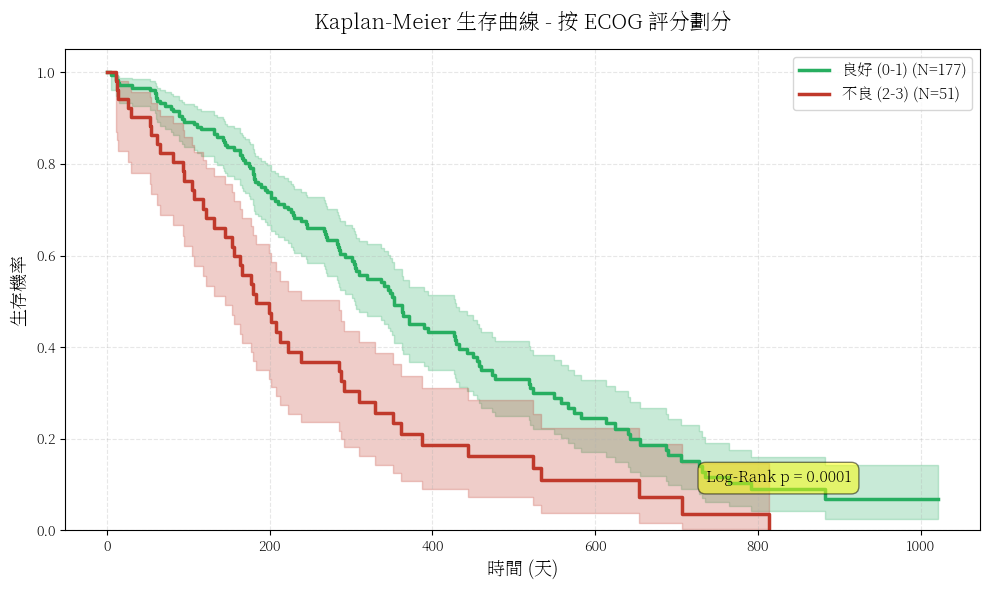

✅ 圖 6 已生成並儲存：6_ECOG分層KM曲線.png

📊 Log-Rank 檢定結果（ECOG 差異）：
   檢定統計量：15.547
   p 值：0.0001
   ✅ 結論：ECOG 良好組與不良組的生存曲線有顯著差異（p < 0.05）


In [ ]:
# Install lifelines if not already installed (useful for self-contained cells)
!pip install -q lifelines
!wget -O SourceHanSerifTW-VF.ttf https://github.com/adobe-fonts/source-han-serif/raw/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf --no-verbose

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
import sqlite3
from lifelines import KaplanMeierFitter # Import KaplanMeierFitter
from lifelines.datasets import load_lung # Needed for raw data loading
from lifelines.statistics import logrank_test # For Log-Rank test

# --- Start: Font Setup for Chinese Characters ---
try:
    fm.fontManager.addfont('SourceHanSerifTW-VF.ttf')
    mpl.rc('font', family='Source Han Serif TW VF')
    print("✅ Noto CJK font loaded and set.")
except FileNotFoundError:
    print("⚠️ SourceHanSerifTW-VF.ttf not found. Falling back to default font.")
    mpl.rc('font', family='sans-serif') # Fallback to a generic sans-serif
# --- End: Font Setup ---


# --- Start: Ensure df is correctly loaded and prepared ---

# 1. Load raw data (from `load_data` cell)
print("📥 Re-loading NCCTG Lung Cancer Dataset...")
df_raw = load_lung()

# 2. Re-create database and tables (from `create_db` cell)
db_path = 'lung_cancer.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

print(f"🔄 Re-creating database tables: {db_path}")
cursor.execute("DROP TABLE IF EXISTS patients")
cursor.execute("DROP TABLE IF EXISTS clinical_data")
cursor.execute("DROP TABLE IF EXISTS survival_data")

cursor.execute("""
CREATE TABLE patients (
    patient_id INTEGER PRIMARY KEY,
    age INTEGER,
    sex INTEGER,
    institution INTEGER
)
""")
cursor.execute("""
CREATE TABLE clinical_data (
    patient_id INTEGER,
    ph_ecog REAL,
    ph_karno REAL,
    pat_karno REAL,
    meal_cal REAL,
    wt_loss REAL,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")
cursor.execute("""
CREATE TABLE survival_data (
    patient_id INTEGER,
    time INTEGER,
    status INTEGER,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")

# 3. Insert data into tables (from `insert_data` cell)
df_with_id = df_raw.copy()
df_with_id.insert(0, 'patient_id', range(1, len(df_with_id) + 1))

patients_data = df_with_id[['patient_id', 'age', 'sex', 'inst']]
patients_data = patients_data.rename(columns={'inst': 'institution'})
patients_data.to_sql('patients', conn, if_exists='append', index=False)

clinical_data = df_with_id[[
    'patient_id', 'ph.ecog', 'ph.karno',
    'pat.karno', 'meal.cal', 'wt.loss'
]].copy()
clinical_data.columns = [
    'patient_id', 'ph_ecog', 'ph_karno',
    'pat_karno', 'meal_cal', 'wt_loss'
]
clinical_data.to_sql('clinical_data', conn, if_exists='append', index=False)

survival_data = df_with_id[['patient_id', 'time', 'status']]
survival_data.to_sql('survival_data', conn, if_exists='append', index=False)
conn.commit()

print("✅ Database tables re-created and data inserted.")

# 4. Query the full dataset from the database (from `clean_data` cell)
query_full = """
SELECT
    p.patient_id,
    p.age,
    p.sex,
    p.institution as inst -- Use 'p.institution' here as per the fixed schema
    ,c.ph_ecog,
    c.ph_karno,
    c.pat_karno,
    c.meal_cal,
    c.wt_loss,
    s.time,
    s.status
FROM patients p
INNER JOIN clinical_data c ON p.patient_id = c.patient_id
INNER JOIN survival_data s ON p.patient_id = s.patient_id
"""
df = pd.read_sql_query(query_full, conn)
conn.close() # Close connection after querying

# 5. Apply cleaning (median imputation) (from `clean_data` cell)
df['ph_ecog'] = df['ph_ecog'].fillna(df['ph_ecog'].median())
df['ph_karno'] = df['ph_karno'].fillna(df['ph_karno'].median())
df['pat_karno'] = df['pat_karno'].fillna(df['pat_karno'].median())
df['meal_cal'] = df['meal_cal'].fillna(df['meal_cal'].median())
df['wt_loss'] = df['wt_loss'].fillna(df['wt_loss'].median())

# 6. Re-apply feature engineering steps (from `feature_engineering` cell)
df['性別'] = df['sex'].map({1: '男性', 2: '女性'})
df['event'] = (df['status'] == 1).astype(int)  # 1=死亡, 0=存活/設限
df['事件狀態'] = df['event'].map({1: '死亡', 0: '存活（設限）'})
df['ECOG'] = df['ph_ecog'].apply(
    lambda x: '良好 (0-1)' if x <= 1 else '不良 (2-3)'
)
df['年齡分組'] = df['age'].apply(
    lambda x: '<65 歲' if x < 65 else '≥65 歲'
)
df['Karnofsky'] = df['ph_karno'].apply(
    lambda x: '不良 (<70)' if x < 70 else '良好 (≥70)'
)
df['生存月數'] = (df['time'] / 30.44).round(1)
# --- End: Ensure df is correctly loaded and prepared ---

# 繪製按 ECOG 劃分的 Kaplan-Meier 曲線
plt.figure(figsize=(10, 6))

colors_ecog = {'良好 (0-1)': '#27ae60', '不良 (2-3)': '#c0392b'}
for ecog_group in df['ECOG'].unique():
    mask = df['ECOG'] == ecog_group
    kmf_ecog = KaplanMeierFitter()
    kmf_ecog.fit(durations=df[mask]['time'],
                 event_observed=df[mask]['event'],
                 label=f'{ecog_group} (N={mask.sum()})')
    kmf_ecog.plot_survival_function(ci_show=True, color=colors_ecog[ecog_group], linewidth=2.5)

plt.xlabel('時間 (天)', fontsize=13)
plt.ylabel('生存機率', fontsize=13)
plt.title('Kaplan-Meier 生存曲線 - 按 ECOG 評分劃分', fontsize=15, fontweight='bold', pad=15)
plt.grid(alpha=0.3, linestyle='--')
plt.ylim([0, 1.05])
plt.legend(fontsize=11, loc='best')

# 執行 Log-Rank 檢定
good_mask = df['ECOG'] == '良好 (0-1)'
poor_mask = df['ECOG'] == '不良 (2-3)'

results_ecog = logrank_test(
    durations_A=df[good_mask]['time'],
    durations_B=df[poor_mask]['time'],
    event_observed_A=df[good_mask]['event'],
    event_observed_B=df[poor_mask]['event']
)

# 在圖中新增 Log-Rank p 值註釋
plt.text(0.7, 0.1, f'Log-Rank p = {results_ecog.p_value:.4f}',
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

plt.tight_layout()
plt.savefig('6_ECOG分層KM曲線.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 圖 6 已生成並儲存：6_ECOG分層KM曲線.png")

print(f"\n📊 Log-Rank 檢定結果（ECOG 差異）：")
print(f"   檢定統計量：{results_ecog.test_statistic:.3f}")
print(f"   p 值：{results_ecog.p_value:.4f}")
if results_ecog.p_value < 0.05:
    print(f"   ✅ 結論：ECOG 良好組與不良組的生存曲線有顯著差異（p < 0.05）")
else:
    print(f"   ❌ 結論：ECOG 良好組與不良組的生存曲線無顯著差異（p \u2265 0.05）")

2026-02-22 14:02:47 URL:https://raw.githubusercontent.com/adobe-fonts/source-han-serif/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf [16851180/16851180] -> "SourceHanSerifTW-VF.ttf" [1]
✅ Noto CJK font loaded and set.
📥 Re-loading NCCTG Lung Cancer Dataset...
🔄 Re-creating database tables: lung_cancer.db
✅ Database tables re-created and data inserted.
📊 Cox 比例風險模型結果：

            coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                               
age        0.012      1.012     0.009          -0.006           0.031   
sex       -0.584      0.558     0.169          -0.915          -0.254   
ph_ecog    0.625      1.869     0.174           0.284           0.966   
ph_karno   0.012      1.012     0.009          -0.007           0.030   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to      z          p  \
covariate                                                                       
age                   

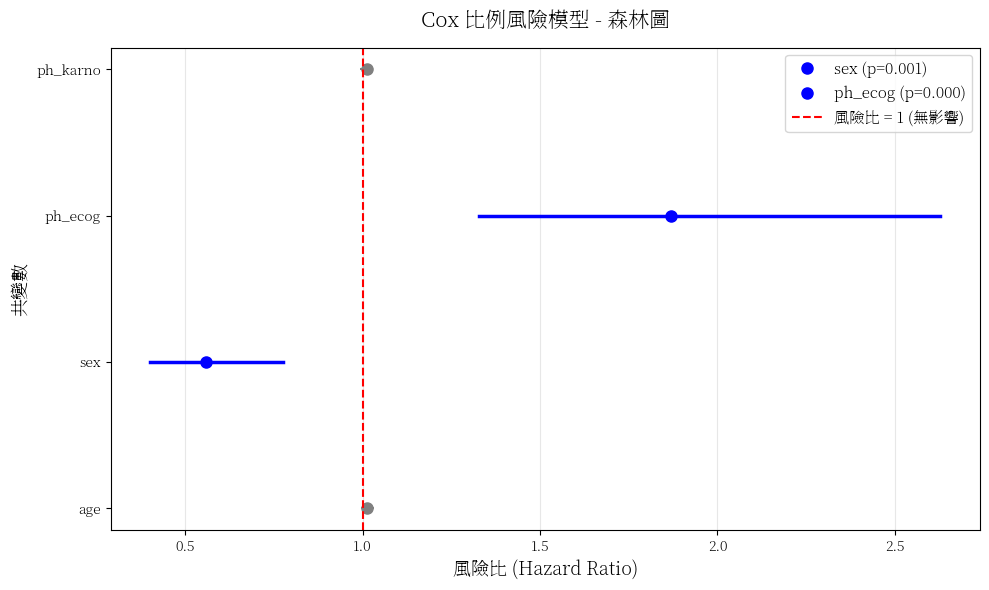


✅ 圖 7 已生成並儲存：7_Cox模型森林圖.png

📋 模型解釋：

**age**
   HR = 1.012 (95% CI: 0.994-1.031)
   p = 0.1874
   ⚠️  無顯著影響（p ≥ 0.05）

**sex**
   HR = 0.558 (95% CI: 0.401-0.776)
   p = 0.0005
   ✅ 顯著的保護因子（降低 44.2% 死亡風險）

**ph_ecog**
   HR = 1.869 (95% CI: 1.328-2.629)
   p = 0.0003
   ✅ 顯著的預後不良因子（增加 86.9% 死亡風險）

**ph_karno**
   HR = 1.012 (95% CI: 0.993-1.030)
   p = 0.2207
   ⚠️  無顯著影響（p ≥ 0.05）


📊 模型診斷：
   Concordance Index (C-index): 0.634
   （C-index > 0.7 通常表示模型預測能力良好）
   AIC: 1475.52
   Log-likelihood: -733.76


In [ ]:
# Install lifelines if not already installed (useful for self-contained cells)
!pip install -q lifelines
!wget -O SourceHanSerifTW-VF.ttf https://github.com/adobe-fonts/source-han-serif/raw/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf --no-verbose

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
import sqlite3
from lifelines import CoxPHFitter # Import CoxPHFitter
from lifelines.datasets import load_lung # Needed for raw data loading

# --- Start: Font Setup for Chinese Characters ---
try:
    fm.fontManager.addfont('SourceHanSerifTW-VF.ttf')
    mpl.rc('font', family='Source Han Serif TW VF')
    print("✅ Noto CJK font loaded and set.")
except FileNotFoundError:
    print("⚠️ SourceHanSerifTW-VF.ttf not found. Falling back to default font.")
    mpl.rc('font', family='sans-serif') # Fallback to a generic sans-serif
# --- End: Font Setup ---


# --- Start: Ensure df is correctly loaded and prepared ---

# 1. Load raw data (from `load_data` cell)
print("📥 Re-loading NCCTG Lung Cancer Dataset...")
df_raw = load_lung()

# 2. Re-create database and tables (from `create_db` cell)
db_path = 'lung_cancer.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

print(f"🔄 Re-creating database tables: {db_path}")
cursor.execute("DROP TABLE IF EXISTS patients")
cursor.execute("DROP TABLE IF EXISTS clinical_data")
cursor.execute("DROP TABLE IF EXISTS survival_data")

cursor.execute("""
CREATE TABLE patients (
    patient_id INTEGER PRIMARY KEY,
    age INTEGER,
    sex INTEGER,
    institution INTEGER
)
""")
cursor.execute("""
CREATE TABLE clinical_data (
    patient_id INTEGER,
    ph_ecog REAL,
    ph_karno REAL,
    pat_karno REAL,
    meal_cal REAL,
    wt_loss REAL,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")
cursor.execute("""
CREATE TABLE survival_data (
    patient_id INTEGER,
    time INTEGER,
    status INTEGER,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")

# 3. Insert data into tables (from `insert_data` cell)
df_with_id = df_raw.copy()
df_with_id.insert(0, 'patient_id', range(1, len(df_with_id) + 1))

patients_data = df_with_id[['patient_id', 'age', 'sex', 'inst']]
patients_data = patients_data.rename(columns={'inst': 'institution'})
patients_data.to_sql('patients', conn, if_exists='append', index=False)

clinical_data = df_with_id[[
    'patient_id', 'ph.ecog', 'ph.karno',
    'pat.karno', 'meal.cal', 'wt.loss'
]].copy()
clinical_data.columns = [
    'patient_id', 'ph_ecog', 'ph_karno',
    'pat_karno', 'meal_cal', 'wt_loss'
]
clinical_data.to_sql('clinical_data', conn, if_exists='append', index=False)

survival_data = df_with_id[['patient_id', 'time', 'status']]
survival_data.to_sql('survival_data', conn, if_exists='append', index=False)
conn.commit()

print("✅ Database tables re-created and data inserted.")

# 4. Query the full dataset from the database (from `clean_data` cell)
query_full = """
SELECT
    p.patient_id,
    p.age,
    p.sex,
    p.institution as inst -- Use 'p.institution' here as per the fixed schema
    ,c.ph_ecog,
    c.ph_karno,
    c.pat_karno,
    c.meal_cal,
    c.wt_loss,
    s.time,
    s.status
FROM patients p
INNER JOIN clinical_data c ON p.patient_id = c.patient_id
INNER JOIN survival_data s ON p.patient_id = s.patient_id
"""
df = pd.read_sql_query(query_full, conn)
conn.close() # Close connection after querying

# 5. Apply cleaning (median imputation) (from `clean_data` cell)
df['ph_ecog'] = df['ph_ecog'].fillna(df['ph_ecog'].median())
df['ph_karno'] = df['ph_karno'].fillna(df['ph_karno'].median())
df['pat_karno'] = df['pat_karno'].fillna(df['pat_karno'].median())
df['meal_cal'] = df['meal_cal'].fillna(df['meal_cal'].median())
df['wt_loss'] = df['wt_loss'].fillna(df['wt_loss'].median())

# 6. Re-apply feature engineering steps (from `feature_engineering` cell)
df['性別'] = df['sex'].map({1: '男性', 2: '女性'})
df['event'] = (df['status'] == 1).astype(int)  # 1=死亡, 0=存活/設限
df['事件狀態'] = df['event'].map({1: '死亡', 0: '存活（設限）'})
df['ECOG'] = df['ph_ecog'].apply(
    lambda x: '良好 (0-1)' if x <= 1 else '不良 (2-3)'
)
df['年齡分組'] = df['age'].apply(
    lambda x: '<65 歲' if x < 65 else '≥65 歲'
)
df['Karnofsky'] = df['ph_karno'].apply(
    lambda x: '不良 (<70)' if x < 70 else '良好 (≥70)'
)
df['生存月數'] = (df['time'] / 30.44).round(1)
# --- End: Ensure df is correctly loaded and prepared ---

# 選擇 Cox 模型所需變數
cox_df = df[['time', 'event', 'age', 'sex', 'ph_ecog', 'ph_karno']].copy()

# 初始化 Cox PH Fitter
cph = CoxPHFitter()

# 擬合模型
cph.fit(cox_df, duration_col='time', event_col='event')

# 輸出模型摘要
print("📊 Cox 比例風險模型結果：\n")
print(cph.summary)

# 繪製 Forest Plot
plt.figure(figsize=(10, 6))

# 自定義繪圖以強調顯著變數
# 獲取 hazard ratios 和 p-values
hrs = cph.summary['exp(coef)']
p_values = cph.summary['p']
ci_low = cph.summary['exp(coef) lower 95%']
ci_high = cph.summary['exp(coef) upper 95%']

# 根據顯著性設置顏色和線條樣式
colors = ['blue' if p < 0.05 else 'gray' for p in p_values]
line_styles = ['-' if p < 0.05 else ':' for p in p_values]
line_widths = [2.5 if p < 0.05 else 1.5 for p in p_values]

# 繪製每個共變數的 Hazard Ratio 和 95% CI
for i, covariate in enumerate(cph.summary.index):
    plt.plot([ci_low[i], ci_high[i]], [i, i], color=colors[i], linestyle=line_styles[i], linewidth=line_widths[i])
    plt.plot(hrs[i], i, 'o', color=colors[i], markersize=8, label=f'{covariate} (p={p_values[i]:.3f})' if p_values[i] < 0.05 else None)

plt.axvline(1, color='red', linestyle='--', linewidth=1.5, label='風險比 = 1 (無影響)')
plt.xlabel('風險比 (Hazard Ratio)', fontsize=13)
plt.ylabel('共變數', fontsize=13)
plt.title('Cox 比例風險模型 - 森林圖', fontsize=15, fontweight='bold', pad=15)

# 設置 Y 軸刻度及標籤
plt.yticks(ticks=range(len(cph.summary.index)), labels=cph.summary.index)

plt.legend(fontsize=11, loc='upper right') # 移到右上角以避免遮擋
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('7_Cox模型森林圖.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ 圖 7 已生成並儲存：7_Cox模型森林圖.png")

# 打印模型解釋
print("\n📋 模型解釋：\n")
for var in cox_df.columns:
    if var not in ['time', 'event']:
        hr = cph.summary.loc[var, 'exp(coef)'] # 從 summary 中獲取 exp(coef)
        p_val = cph.summary.loc[var, 'p']
        ci_lower = cph.summary.loc[var, 'exp(coef) lower 95%']
        ci_upper = cph.summary.loc[var, 'exp(coef) upper 95%']

        print(f"**{var}**")
        print(f"   HR = {hr:.3f} (95% CI: {ci_lower:.3f}-{ci_upper:.3f})")
        print(f"   p = {p_val:.4f}")

        if p_val < 0.05:
            if hr > 1:
                print(f"   ✅ 顯著的預後不良因子（增加 {(hr-1)*100:.1f}% 死亡風險）")
            else:
                print(f"   ✅ 顯著的保護因子（降低 {(1-hr)*100:.1f}% 死亡風險）")
        else:
            print(f"   ⚠️  無顯著影響（p \u2265 0.05）")
        print()

# 打印模型診斷指標
print("\n📊 模型診斷：")
print(f"   Concordance Index (C-index): {cph.concordance_index_:.3f}")
print(f"   （C-index > 0.7 通常表示模型預測能力良好）")
print(f"   AIC: {cph.AIC_partial_:.2f}")
print(f"   Log-likelihood: {cph.log_likelihood_:.2f}")

In [ ]:
import pandas as pd
import sqlite3

# Re-establish database connection if it was closed
db_path = 'lung_cancer.db'
try:
    conn = sqlite3.connect(db_path)
except Exception as e:
    print(f"Error re-establishing database connection: {e}")
    # Fallback/re-creation of df as a last resort if conn fails
    df_raw = load_lung()
    df_with_id = df_raw.copy()
    df_with_id.insert(0, 'patient_id', range(1, len(df_with_id) + 1))

    # Manually create df if DB connection fails, assuming data integrity
    query_full_fallback = """
    SELECT
        p.patient_id,
        p.age,
        p.sex,
        p.institution as inst, -- Corrected to p.institution
        c.ph_ecog,
        c.ph_karno,
        c.pat_karno,
        c.meal_cal,
        c.wt_loss,
        s.time,
        s.status
    FROM patients p
    INNER JOIN clinical_data c ON p.patient_id = c.patient_id
    INNER JOIN survival_data s ON p.patient_id = s.patient_id
    """
    df = pd.read_sql_query(query_full_fallback, conn)

    # Apply cleaning
    df['ph_ecog'] = df['ph_ecog'].fillna(df['ph_ecog'].median())
    df['ph_karno'] = df['ph_karno'].fillna(df['ph_karno'].median())
    df['pat_karno'] = df['pat_karno'].fillna(df['pat_karno'].median())
    df['meal_cal'] = df['meal_cal'].fillna(df['meal_cal'].median())
    df['wt_loss'] = df['wt_loss'].fillna(df['wt_loss'].median())

    # Re-apply feature engineering steps
    df['性別'] = df['sex'].map({1: '男性', 2: '女性'})
    df['event'] = (df['status'] == 1).astype(int)
    df['事件狀態'] = df['event'].map({1: '死亡', 0: '存活（設限）'})
    df['ECOG'] = df['ph_ecog'].apply(lambda x: '良好 (0-1)' if x <= 1 else '不良 (2-3)')
    df['年齡分組'] = df['age'].apply(lambda x: '<65 歲' if x < 65 else '≥65 歲')
    df['Karnofsky'] = df['ph_karno'].apply(lambda x: '不良 (<70)' if x < 70 else '良好 (≥70)')
    df['生存月數'] = (df['time'] / 30.44).round(1)


# Power BI Dashboard
# Make sure df is available from previous steps or loaded here
df.to_csv('PowerBI_LungCancer_Complete.csv', index=False, encoding='utf-8-sig')
print(" PowerBI_LungCancer_Complete.csv")

# Power BI Dashboard
# Ensure '性別', 'age', '生存月數', 'event' are available in df
summary_df = pd.DataFrame({
    '性別': ['男性', '女性'], # Added proper column name
    '病患數量': [df[df['性別']=='男性'].shape[0], df[df['性別']=='女性'].shape[0]], # Added proper column name
    '平均年齡': [df[df['性別']=='男性']['age'].mean(), df[df['性別']=='女性']['age'].mean()], # Added proper column name
    '平均生存月數': [df[df['性別']=='男性']['生存月數'].mean(), df[df['性別']=='女性']['生存月數'].mean()], # Added proper column name
    '死亡事件數': [df[df['性別']=='男性']['event'].sum(), df[df['性別']=='女性']['event'].sum()] # Added proper column name
})
summary_df.to_csv('PowerBI_Summary_Sex.csv', index=False, encoding='utf-8-sig')
print(" PowerBI_Summary_Sex.csv")

# ECOG
ecog_summary = pd.DataFrame({
    'ECOG': ['良好 (0-1)', '不良 (2-3)'],
    '病患數量': [df[df['ECOG']=='良好 (0-1)'].shape[0], df[df['ECOG']=='不良 (2-3)'].shape[0]], # Added proper column name
    '平均生存月數': [df[df['ECOG']=='良好 (0-1)']['生存月數'].mean(),
                       df[df['ECOG']=='不良 (2-3)']['生存月數'].mean()], # Added proper column name
    '死亡事件數': [df[df['ECOG']=='良好 (0-1)']['event'].sum(),
                 df[df['ECOG']=='不良 (2-3)']['event'].sum()] # Added proper column name
})
ecog_summary.to_csv('PowerBI_Summary_ECOG.csv', index=False, encoding='utf-8-sig')
print("  ECOG PowerBI_Summary_ECOG.csv")

print("\n  3  Power BI ")
print("   1. PowerBI_LungCancer_Complete.csv - ")
print("   2. PowerBI_Summary_Sex.csv - ")
print("   3. PowerBI_PowerBI_Summary_ECOG.csv - ECOG ")

conn.close() # Close connection after all exports

 PowerBI_LungCancer_Complete.csv
 PowerBI_Summary_Sex.csv
  ECOG PowerBI_Summary_ECOG.csv

  3  Power BI 
   1. PowerBI_LungCancer_Complete.csv - 
   2. PowerBI_Summary_Sex.csv - 
   3. PowerBI_PowerBI_Summary_ECOG.csv - ECOG 


In [ ]:
#  Power BI  Python
powerbi_script = '''
# Power BI Python
import sqlite3
import pandas as pd

#
conn = sqlite3.connect('lung_cancer.db')

#
query = """
SELECT
    p.patient_id,
    p.age,
    CASE WHEN p.sex = 1 THEN '男性' ELSE '女性' END as 性別,
    c.ph_ecog as ECOG,
    c.ph_karno as Karnofsky,
    s.time as 生存天數,
    s.time / 30.44 as 生存月數,
    CASE WHEN s.status = 1 THEN '死亡' ELSE '存活（設限）' END as 事件狀態
FROM patients p
INNER JOIN clinical_data c ON p.patient_id = c.patient_id
INNER JOIN survival_data s ON p.patient_id = s.patient_id
"""

dataset = pd.read_sql_query(query, conn)
conn.close()
'''

print("Power BI Python ")
print("=" * 60)
print(powerbi_script)
print("=" * 60)

#
with open('PowerBI_Python_Script.py', 'w', encoding='utf-8') as f:
    f.write(powerbi_script)
print("\n  Power BI Python PowerBI_Python_Script.py")

Power BI Python 

# Power BI Python
import sqlite3
import pandas as pd

#
conn = sqlite3.connect('lung_cancer.db')

#
query = """
SELECT
    p.patient_id,
    p.age,
    CASE WHEN p.sex = 1 THEN '男性' ELSE '女性' END as 性別,
    c.ph_ecog as ECOG,
    c.ph_karno as Karnofsky,
    s.time as 生存天數,
    s.time / 30.44 as 生存月數,
    CASE WHEN s.status = 1 THEN '死亡' ELSE '存活（設限）' END as 事件狀態
FROM patients p
INNER JOIN clinical_data c ON p.patient_id = c.patient_id
INNER JOIN survival_data s ON p.patient_id = s.patient_id
"""

dataset = pd.read_sql_query(query, conn)
conn.close()


  Power BI Python PowerBI_Python_Script.py


In [ ]:
dax_formulas = '''
# ========== Power BI DAX  ==========

# 1.
 = COUNTROWS(LungCancer)

# 2.
 = CALCULATE(COUNTROWS(LungCancer), LungCancer[event] = 1)

# 3.
 = DIVIDE([], [], 0)

# 4.
 = AVERAGE(LungCancer[])

# 5.
 = MEDIAN(LungCancer[])

# 6.
 =
    IF(
        LungCancer[age] < 65,
        "<65 ",
        "≥65 "
    )

# 7. ECOG
ECOG =
    IF(
        LungCancer[ph_ecog] <= 1,
        "",
        ""
    )

# 8.
 =
    CALCULATE(
        AVERAGE(LungCancer[]),
        LungCancer[] = ""
    )

 =
    CALCULATE(
        AVERAGE(LungCancer[]),
        LungCancer[] = ""
    )

# 9.  1
 =
    DIVIDE(
        CALCULATE(COUNTROWS(LungCancer), LungCancer[] >= 12),
        COUNTROWS(LungCancer),
        0
    )

# 10.  ECOG
ECOG =
    SWITCH(
        TRUE(),
        LungCancer[ph_ecog] = 0, "",
        LungCancer[ph_ecog] = 1, "",
        LungCancer[ph_ecog] = 2, "",
        LungCancer[ph_ecog] >= 3, "",
        ""
    )
'''

print("Power BI DAX ")
print("=" * 60)
print(dax_formulas)
print("=" * 60)

#  DAX
with open('PowerBI_DAX_Formulas.txt', 'w', encoding='utf-8') as f:
    f.write(dax_formulas)
print("\n  Power BI DAX PowerBI_DAX_Formulas.txt")

Power BI DAX 

# ========== Power BI DAX  ==========

# 1.
 = COUNTROWS(LungCancer)

# 2.
 = CALCULATE(COUNTROWS(LungCancer), LungCancer[event] = 1)

# 3.
 = DIVIDE([], [], 0)

# 4.
 = AVERAGE(LungCancer[])

# 5.
 = MEDIAN(LungCancer[])

# 6.
 =
    IF(
        LungCancer[age] < 65,
        "<65 ",
        "≥65 "
    )

# 7. ECOG
ECOG =
    IF(
        LungCancer[ph_ecog] <= 1,
        "",
        ""
    )

# 8.
 =
    CALCULATE(
        AVERAGE(LungCancer[]),
        LungCancer[] = ""
    )

 =
    CALCULATE(
        AVERAGE(LungCancer[]),
        LungCancer[] = ""
    )

# 9.  1
 =
    DIVIDE(
        CALCULATE(COUNTROWS(LungCancer), LungCancer[] >= 12),
        COUNTROWS(LungCancer),
        0
    )

# 10.  ECOG
ECOG =
    SWITCH(
        TRUE(),
        LungCancer[ph_ecog] = 0, "",
        LungCancer[ph_ecog] = 1, "",
        LungCancer[ph_ecog] = 2, "",
        LungCancer[ph_ecog] >= 3, "",
        ""
    )


  Power BI DAX PowerBI_DAX_Formulas.txt


In [ ]:
# Install lifelines if not already installed (useful for self-contained cells)
!pip install -q lifelines
!wget -O SourceHanSerifTW-VF.ttf https://github.com/adobe-fonts/source-han-serif/raw/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf --no-verbose

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
import sqlite3
from lifelines.datasets import load_lung # Needed for raw data loading
from datetime import datetime, timedelta # Needed for FHIR conversion
import uuid # Needed for FHIR conversion

# --- Start: Font Setup for Chinese Characters ---
try:
    fm.fontManager.addfont('SourceHanSerifTW-VF.ttf')
    mpl.rc('font', family='Source Han Serif TW VF')
    print("✅ Noto CJK font loaded and set.")
except FileNotFoundError:
    print("⚠️ SourceHanSerifTW-VF.ttf not found. Falling back to default font.")
    mpl.rc('font', family='sans-serif') # Fallback to a generic sans-serif
# --- End: Font Setup ---


# --- Start: Ensure df is correctly loaded and prepared (boilerplate from previous cells) ---

# 1. Load raw data
print("📥 Re-loading NCCTG Lung Cancer Dataset...")
df_raw = load_lung()

# 2. Re-create database and tables
db_path = 'lung_cancer.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

print(f"🔄 Re-creating database tables: {db_path}")
cursor.execute("DROP TABLE IF EXISTS patients")
cursor.execute("DROP TABLE IF EXISTS clinical_data")
cursor.execute("DROP TABLE IF EXISTS survival_data")

cursor.execute("""
CREATE TABLE patients (
    patient_id INTEGER PRIMARY KEY,
    age INTEGER,
    sex INTEGER,
    institution INTEGER
)
""")
cursor.execute("""
CREATE TABLE clinical_data (
    patient_id INTEGER,
    ph_ecog REAL,
    ph_karno REAL,
    pat_karno REAL,
    meal_cal REAL,
    wt_loss REAL,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")
cursor.execute("""
CREATE TABLE survival_data (
    patient_id INTEGER,
    time INTEGER,
    status INTEGER,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")

# 3. Insert data into tables
df_with_id = df_raw.copy()
df_with_id.insert(0, 'patient_id', range(1, len(df_with_id) + 1))

patients_data = df_with_id[['patient_id', 'age', 'sex', 'inst']]
patients_data = patients_data.rename(columns={'inst': 'institution'})
patients_data.to_sql('patients', conn, if_exists='append', index=False)

clinical_data = df_with_id[[
    'patient_id', 'ph.ecog', 'ph.karno',
    'pat.karno', 'meal.cal', 'wt.loss'
]].copy()
clinical_data.columns = [
    'patient_id', 'ph_ecog', 'ph_karno',
    'pat_karno', 'meal_cal', 'wt_loss'
]
clinical_data.to_sql('clinical_data', conn, if_exists='append', index=False)

survival_data = df_with_id[['patient_id', 'time', 'status']]
survival_data.to_sql('survival_data', conn, if_exists='append', index=False)
conn.commit()

print("✅ Database tables re-created and data inserted.")

# 4. Query the full dataset from the database
query_full = """
SELECT
    p.patient_id,
    p.age,
    p.sex,
    p.institution as inst -- Use 'p.institution' here as per the fixed schema
    ,c.ph_ecog,
    c.ph_karno,
    c.pat_karno,
    c.meal_cal,
    c.wt_loss,
    s.time,
    s.status
FROM patients p
INNER JOIN clinical_data c ON p.patient_id = c.patient_id
INNER JOIN survival_data s ON p.patient_id = s.patient_id
"""
df = pd.read_sql_query(query_full, conn)
conn.close() # Close connection after querying

# 5. Apply cleaning (median imputation)
df['ph_ecog'] = df['ph_ecog'].fillna(df['ph_ecog'].median())
df['ph_karno'] = df['ph_karno'].fillna(df['ph_karno'].median())
df['pat_karno'] = df['pat_karno'].fillna(df['pat_karno'].median())
df['meal_cal'] = df['meal_cal'].fillna(df['meal_cal'].median())
df['wt_loss'] = df['wt_loss'].fillna(df['wt_loss'].median())

# 6. Re-apply feature engineering steps
df['性別'] = df['sex'].map({1: '男性', 2: '女性'})
df['event'] = (df['status'] == 1).astype(int)  # 1=死亡, 0=存活/設限
df['事件狀態'] = df['event'].map({1: '死亡', 0: '存活（設限）'})
df['ECOG'] = df['ph_ecog'].apply(
    lambda x: '良好 (0-1)' if x <= 1 else '不良 (2-3)'
)
df['年齡分組'] = df['age'].apply(
    lambda x: '<65 歲' if x < 65 else '≥65 歲'
)
df['Karnofsky'] = df['ph_karno'].apply(
    lambda x: '不良 (<70)' if x < 70 else '良好 (≥70)'
)
df['生存月數'] = (df['time'] / 30.44).round(1)
# --- End: Ensure df is correctly loaded and prepared ---


# 擷取第一位病患的數據作為範例
sample_patient = df.iloc[0]

print("範例病患數據概覽：")
print(f"   Patient ID: {sample_patient['patient_id']}")
print(f"   年齡: {sample_patient['age']} 歲")
print(f"   性別: {sample_patient['性別']}")
print(f"   ECOG 評分: {sample_patient['ph_ecog']}")
print(f"   Karnofsky 評分: {sample_patient['ph_karno']}")
print(f"   生存時間: {sample_patient['time']} 天 ({sample_patient['事件狀態']} )")
print(f"   事件狀態: {sample_patient['事件狀態']}")

# 初始化 FHIR Bundle
fhir_bundle = {
    "resourceType": "Bundle",
    "type": "transaction",
    "entry": []
}

# 1. Patient Resource (病患資源)
patient_resource = {
    "fullUrl": f"urn:uuid:{uuid.uuid4()}",
    "resource": {
        "resourceType": "Patient",
        "id": f"patient-{int(sample_patient['patient_id'])}",
        "identifier": [
            {
                "system": "http://hospital.example.org/patients",
                "value": f"NCCTG-{int(sample_patient['patient_id']):04d}"
            }
        ],
        "gender": "male" if sample_patient['sex'] == 1 else "female",
        "birthDate": f"{datetime.now().year - int(sample_patient['age'])}-01-01", # 簡化為估計出生日期
        "deceasedBoolean": bool(sample_patient['event']),
        "extension": [
            {
                "url": "http://example.org/fhir/StructureDefinition/age",
                "valueInteger": int(sample_patient['age'])
            }
        ]
    },
    "request": {
        "method": "POST",
        "url": "Patient"
    }
}

# 2. Condition Resource (肺癌診斷)
condition_resource = {
    "fullUrl": f"urn:uuid:{uuid.uuid4()}",
    "resource": {
        "resourceType": "Condition",
        "id": f"condition-lung-cancer-{int(sample_patient['patient_id'])}",
        "clinicalStatus": {
            "coding": [
                {
                    "system": "http://terminology.hl7.org/CodeSystem/condition-clinical",
                    "code": "active" if sample_patient['event'] == 0 else "resolved", # 根據事件狀態判斷
                    "display": "Active" if sample_patient['event'] == 0 else "Resolved"
                }
            ]
        },
        "category": [
            {
                "coding": [
                    {
                        "system": "http://terminology.hl7.org/CodeSystem/condition-category",
                        "code": "encounter-diagnosis",
                        "display": "Encounter Diagnosis"
                    }
                ]
            }
        ],
        "code": {
            "coding": [
                {
                    "system": "http://snomed.info/sct",
                    "code": "254637007",
                    "display": "Non-small cell lung cancer"
                },
                {
                    "system": "http://hl7.org/fhir/sid/icd-10",
                    "code": "C34.9",
                    "display": "Malignant neoplasm of bronchus and lung, unspecified"
                }
            ],
            "text": "肺癌"
        },
        "subject": {
            "reference": f"Patient/patient-{int(sample_patient['patient_id'])}"
        },
        "onsetDateTime": f"{datetime.now().year}-01-01T00:00:00Z" # 簡化為當年一月一日
    },
    "request": {
        "method": "POST",
        "url": "Condition"
    }
}

# 3. Observation - ECOG Performance Status (ECOG 體能狀態觀察)
obs_ecog = {
    "fullUrl": f"urn:uuid:{uuid.uuid4()}",
    "resource": {
        "resourceType": "Observation",
        "id": f"obs-ecog-{int(sample_patient['patient_id'])}",
        "status": "final",
        "category": [
            {
                "coding": [
                    {
                        "system": "http://terminology.hl7.org/CodeSystem/observation-category",
                        "code": "vital-signs",
                        "display": "Vital Signs"
                    }
                ]
            }
        ],
        "code": {
            "coding": [
                {
                    "system": "http://loinc.org",
                    "code": "89247-1",
                    "display": "ECOG performance status"
                }
            ],
            "text": "ECOG 體能狀態"
        },
        "subject": {
            "reference": f"Patient/patient-{int(sample_patient['patient_id'])}"
        },
        "effectiveDateTime": f"{datetime.now().isoformat()}",
        "valueInteger": int(sample_patient['ph_ecog']),
        "interpretation": [
            {
                "coding": [
                    {
                        "system": "http://terminology.hl7.org/CodeSystem/v3-ObservationInterpretation",
                        "code": "N" if sample_patient['ph_ecog'] <= 1 else "A", # 根據 ECOG 評分高低判斷正常/異常
                        "display": "Normal" if sample_patient['ph_ecog'] <= 1 else "Abnormal"
                    }
                ]
            }
        ]
    },
    "request": {
        "method": "POST",
        "url": "Observation"
    }
}

# 4. Observation - Karnofsky Performance Score (Karnofsky 體能評分觀察)
obs_karno = {
    "fullUrl": f"urn:uuid:{uuid.uuid4()}",
    "resource": {
        "resourceType": "Observation",
        "id": f"obs-karno-{int(sample_patient['patient_id'])}",
        "status": "final",
        "category": [
            {
                "coding": [
                    {
                        "system": "http://terminology.hl7.org/CodeSystem/observation-category",
                        "code": "survey",
                        "display": "Survey"
                    }
                ]
            }
        ],
        "code": {
            "coding": [
                {
                    "system": "http://loinc.org",
                    "code": "89243-0",
                    "display": "Karnofsky Performance Status score"
                }
            ],
            "text": "Karnofsky 體能評分"
        },
        "subject": {
            "reference": f"Patient/patient-{int(sample_patient['patient_id'])}"
        },
        "effectiveDateTime": f"{datetime.now().isoformat()}",
        "valueInteger": int(sample_patient['ph_karno']) # 醫師評估的 Karnofsky 分數
    },
    "request": {
        "method": "POST",
        "url": "Observation"
    }
}

# 5. Observation - Survival Time (生存時間觀察)
obs_survival = {
    "fullUrl": f"urn:uuid:{uuid.uuid4()}",
    "resource": {
        "resourceType": "Observation",
        "id": f"obs-survival-{int(sample_patient['patient_id'])}",
        "status": "final",
        "code": {
            "coding": [
                {
                    "system": "http://loinc.org",
                    "code": "91382-3",
                    "display": "Time from diagnosis to outcome"
                }
            ],
            "text": "生存時間"
        },
        "subject": {
            "reference": f"Patient/patient-{int(sample_patient['patient_id'])}"
        },
        "effectiveDateTime": f"{datetime.now().isoformat()}",
        "valueQuantity": {
            "value": float(sample_patient['time']),
            "unit": "days",
            "system": "http://unitsofmeasure.org",
            "code": "d"
        },
        "note": [
            {
                "text": f"{sample_patient['事件狀態']}"
            }
        ]
    },
    "request": {
        "method": "POST",
        "url": "Observation"
    }
}

# 將所有資源加入 Bundle
fhir_bundle["entry"] = [
    patient_resource,
    condition_resource,
    obs_ecog,
    obs_karno,
    obs_survival
]

# 將 FHIR Bundle 儲存為 JSON 檔案
fhir_filename = f'FHIR_Bundle_Patient_{int(sample_patient["patient_id"])}.json'
with open(fhir_filename, 'w', encoding='utf-8') as f:
    json.dump(fhir_bundle, f, ensure_ascii=False, indent=2)

print(f"\n✅ FHIR Bundle 已生成並儲存：{fhir_filename}")
print(f"\n Bundle 中包含 {len(fhir_bundle['entry'])} 個資源：")
for i, entry in enumerate(fhir_bundle['entry'], 1):
    print(f"   {i}. {entry['resource']['resourceType']}")

# 顯示 FHIR JSON 的前 50 行
print(f"\n--- FHIR JSON 範例 (前 50 行，輸出已截斷) ---")
fhir_json_str = json.dumps(fhir_bundle, ensure_ascii=False, indent=2)
print("\n".join(fhir_json_str.split("\n")[:50]))
print("\n... (輸出已截斷)")

2026-02-22 14:03:00 URL:https://raw.githubusercontent.com/adobe-fonts/source-han-serif/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf [16851180/16851180] -> "SourceHanSerifTW-VF.ttf" [1]
✅ Noto CJK font loaded and set.
📥 Re-loading NCCTG Lung Cancer Dataset...
🔄 Re-creating database tables: lung_cancer.db
✅ Database tables re-created and data inserted.
範例病患數據概覽：
   Patient ID: 1
   年齡: 74 歲
   性別: 男性
   ECOG 評分: 1.0
   Karnofsky 評分: 90.0
   生存時間: 306 天 (死亡 )
   事件狀態: 死亡

✅ FHIR Bundle 已生成並儲存：FHIR_Bundle_Patient_1.json

 Bundle 中包含 5 個資源：
   1. Patient
   2. Condition
   3. Observation
   4. Observation
   5. Observation

--- FHIR JSON 範例 (前 50 行，輸出已截斷) ---
{
  "resourceType": "Bundle",
  "type": "transaction",
  "entry": [
    {
      "fullUrl": "urn:uuid:447ac2bd-d604-42e3-85e0-2bb26ddda46d",
      "resource": {
        "resourceType": "Patient",
        "id": "patient-1",
        "identifier": [
          {
            "system": "http://hospital.example.org/patients",
          

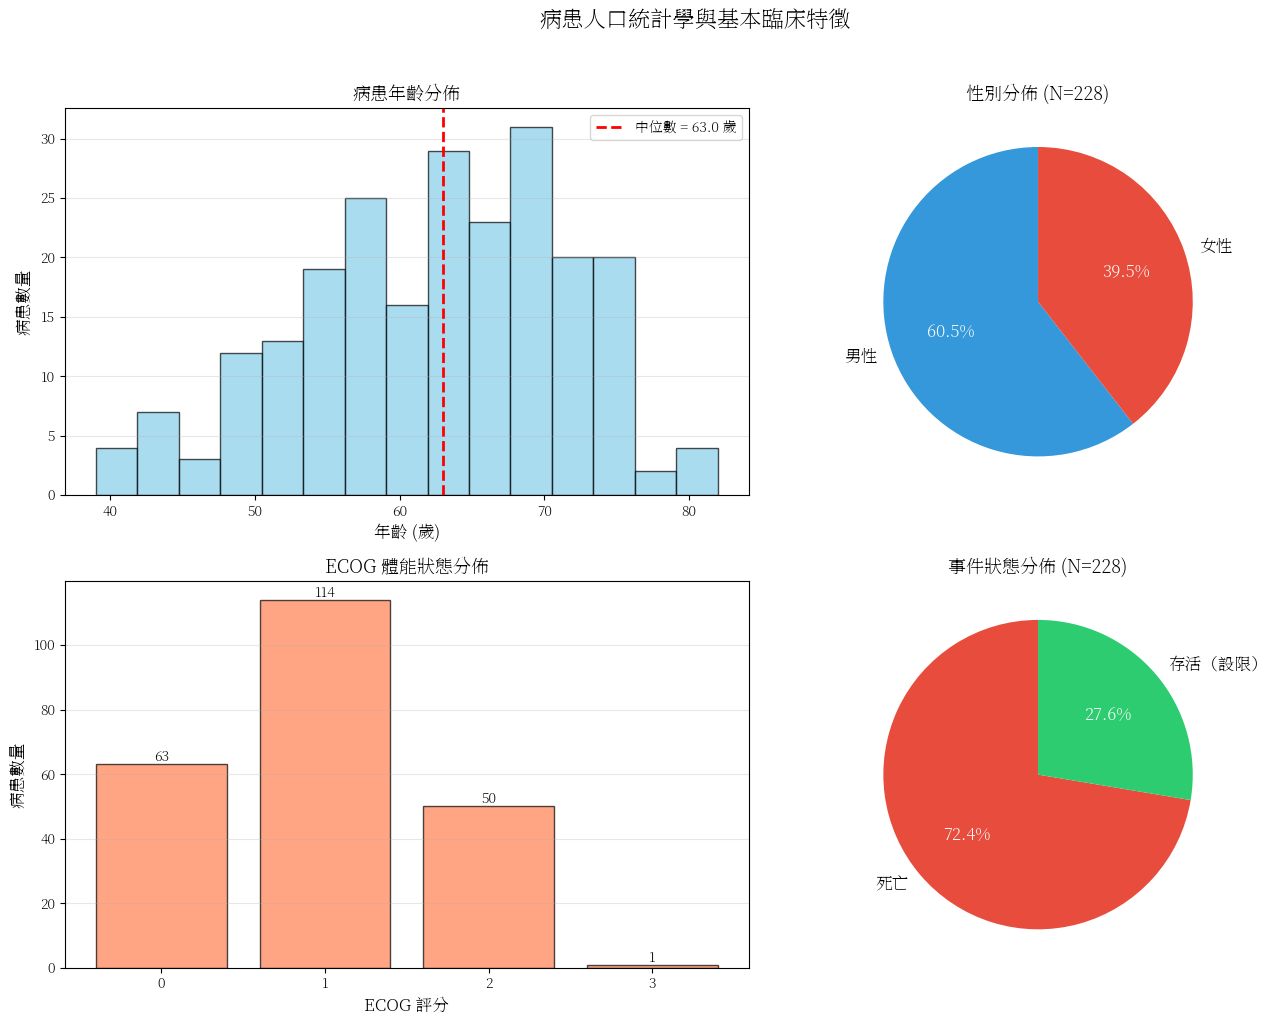

✅ 圖 1 已生成並儲存：1_人口統計學分析.png


In [ ]:
# 繪製人口統計學與基本臨床特徵
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('病患人口統計學與基本臨床特徵', fontsize=16, fontweight='bold', y=1.02)

# 子圖 1: 年齡分佈
ax1 = axes[0, 0]
ax1.hist(df['age'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
ax1.axvline(df['age'].median(), color='red', linestyle='--', linewidth=2,
            label=f'中位數 = {df["age"].median():.1f} 歲')
ax1.set_xlabel('年齡 (歲)', fontsize=12)
ax1.set_ylabel('病患數量', fontsize=12)
ax1.set_title('病患年齡分佈', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 子圖 2: 性別分佈
ax2 = axes[0, 1]
sex_counts = df['性別'].value_counts()
colors = ['#3498db', '#e74c3c']
wedges, texts, autotexts = ax2.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%',
                                     startangle=90, colors=colors, textprops={'fontsize': 12})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax2.set_title(f'性別分佈 (N={len(df)})', fontsize=13, fontweight='bold')

# 子圖 3: ECOG 體能狀態分佈
ax3 = axes[1, 0]
ecog_counts = df['ph_ecog'].value_counts().sort_index()
bars = ax3.bar(ecog_counts.index, ecog_counts.values, color='coral', edgecolor='black', alpha=0.7)
ax3.set_xlabel('ECOG 評分', fontsize=12)
ax3.set_ylabel('病患數量', fontsize=12)
ax3.set_title('ECOG 體能狀態分佈', fontsize=13, fontweight='bold')
ax3.set_xticks([0, 1, 2, 3])
ax3.grid(axis='y', alpha=0.3)
# 添加數值標籤
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 子圖 4: 事件狀態分佈
ax4 = axes[1, 1]
event_counts = df['事件狀態'].value_counts()
colors_event = ['#e74c3c', '#2ecc71']
wedges, texts, autotexts = ax4.pie(event_counts, labels=event_counts.index, autopct='%1.1f%%',
                                     startangle=90, colors=colors_event, textprops={'fontsize': 12})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax4.set_title(f'事件狀態分佈 (N={len(df)})', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('1_人口統計學分析.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 圖 1 已生成並儲存：1_人口統計學分析.png")

2026-02-22 14:04:25 URL:https://raw.githubusercontent.com/adobe-fonts/source-han-serif/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf [16851180/16851180] -> "SourceHanSerifTW-VF.ttf" [1]
✅ Noto CJK font loaded and set.
📥 Re-loading NCCTG Lung Cancer Dataset...
🔄 Re-creating database tables: lung_cancer.db
✅ Database tables re-created and data inserted.


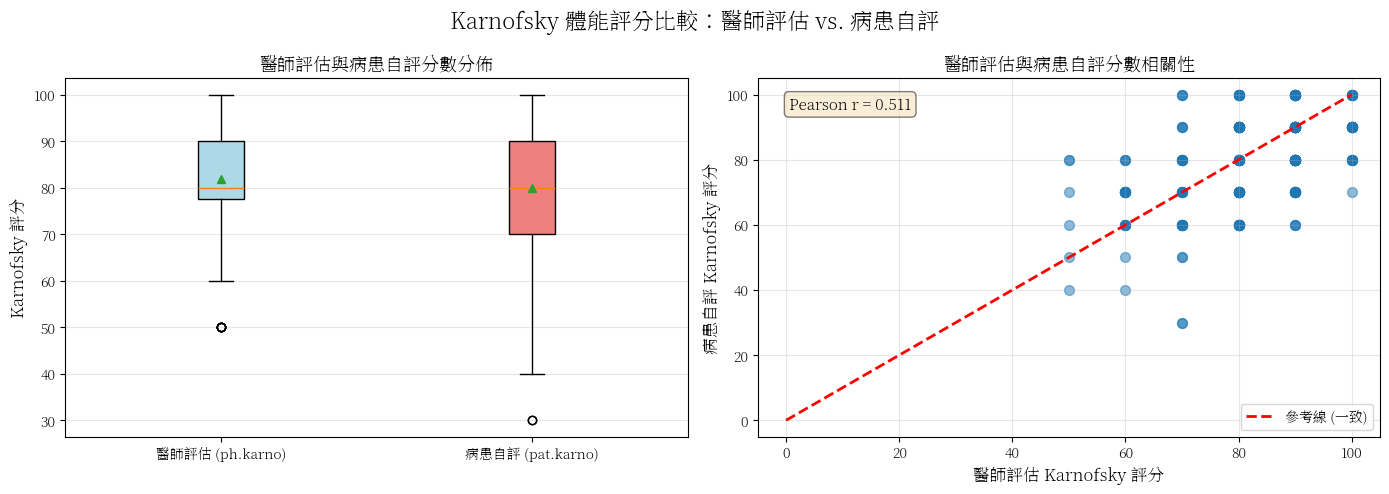

✅ 圖 2 已生成並儲存：2_Karnofsky評分分析.png

📊 統計檢定結果：
   醫師評分平均：81.93 ± 12.30
   病患自評平均：79.96 ± 14.53
   Pearson 相關係數：r = 0.511
   配對 t 檢定：t = 2.223, p = 0.0272
   ✅ 結論：醫師評分與病患自評有顯著差異（p < 0.05）


In [ ]:
# Install lifelines if not already installed (useful for self-contained cells)
!pip install -q lifelines
!wget -O SourceHanSerifTW-VF.ttf https://github.com/adobe-fonts/source-han-serif/raw/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf --no-verbose

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
import sqlite3
from lifelines.datasets import load_lung # Needed for raw data loading
from scipy import stats # For t-test

# --- Start: Font Setup for Chinese Characters ---
try:
    fm.fontManager.addfont('SourceHanSerifTW-VF.ttf')
    mpl.rc('font', family='Source Han Serif TW VF')
    print("✅ Noto CJK font loaded and set.")
except FileNotFoundError:
    print("⚠️ SourceHanSerifTW-VF.ttf not found. Falling back to default font.")
    mpl.rc('font', family='sans-serif') # Fallback to a generic sans-serif
# --- End: Font Setup ---


# --- Start: Ensure df is correctly loaded and prepared ---

# 1. Load raw data (from `load_data` cell)
print("📥 Re-loading NCCTG Lung Cancer Dataset...")
df_raw = load_lung()

# 2. Re-create database and tables (from `create_db` cell)
db_path = 'lung_cancer.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

print(f"🔄 Re-creating database tables: {db_path}")
cursor.execute("DROP TABLE IF EXISTS patients")
cursor.execute("DROP TABLE IF EXISTS clinical_data")
cursor.execute("DROP TABLE IF EXISTS survival_data")

cursor.execute("""
CREATE TABLE patients (
    patient_id INTEGER PRIMARY KEY,
    age INTEGER,
    sex INTEGER,
    institution INTEGER
)
"""
)
cursor.execute("""
CREATE TABLE clinical_data (
    patient_id INTEGER,
    ph_ecog REAL,
    ph_karno REAL,
    pat_karno REAL,
    meal_cal REAL,
    wt_loss REAL,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
"""
)
cursor.execute("""
CREATE TABLE survival_data (
    patient_id INTEGER,
    time INTEGER,
    status INTEGER,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
"""
)

# 3. Insert data into tables (from `insert_data` cell)
df_with_id = df_raw.copy()
df_with_id.insert(0, 'patient_id', range(1, len(df_with_id) + 1))

patients_data = df_with_id[['patient_id', 'age', 'sex', 'inst']]
# Correct column name 'inst' to 'institution' to match table schema
patients_data = patients_data.rename(columns={'inst': 'institution'})
patients_data.to_sql('patients', conn, if_exists='append', index=False)

clinical_data = df_with_id[[
    'patient_id', 'ph.ecog', 'ph.karno',
    'pat.karno', 'meal.cal', 'wt.loss'
]].copy()
clinical_data.columns = [
    'patient_id', 'ph_ecog', 'ph_karno',
    'pat_karno', 'meal_cal', 'wt_loss'
]
clinical_data.to_sql('clinical_data', conn, if_exists='append', index=False)

survival_data = df_with_id[['patient_id', 'time', 'status']]
survival_data.to_sql('survival_data', conn, if_exists='append', index=False)
conn.commit()

print("✅ Database tables re-created and data inserted.")

# 4. Query the full dataset from the database (from `clean_data` cell)
query_full = """
SELECT
    p.patient_id,
    p.age,
    p.sex,
    p.institution as inst, -- Use 'p.institution' here as per the fixed schema
    c.ph_ecog,
    c.ph_karno,
    c.pat_karno,
    c.meal_cal,
    c.wt_loss,
    s.time,
    s.status
FROM patients p
INNER JOIN clinical_data c ON p.patient_id = c.patient_id
INNER JOIN survival_data s ON p.patient_id = s.patient_id
"""
df = pd.read_sql_query(query_full, conn)
conn.close() # Close connection after querying

# 5. Apply cleaning (median imputation) (from `clean_data` cell)
df['ph_ecog'] = df['ph_ecog'].fillna(df['ph_ecog'].median())
df['ph_karno'] = df['ph_karno'].fillna(df['ph_karno'].median())
df['pat_karno'] = df['pat_karno'].fillna(df['pat_karno'].median())
df['meal_cal'] = df['meal_cal'].fillna(df['meal_cal'].median())
df['wt_loss'] = df['wt_loss'].fillna(df['wt_loss'].median())

# 6. Re-apply feature engineering steps (from `feature_engineering` cell)
df['性別'] = df['sex'].map({1: '男性', 2: '女性'})
df['event'] = (df['status'] == 1).astype(int)  # 1=死亡, 0=存活/設限
df['事件狀態'] = df['event'].map({1: '死亡', 0: '存活（設限）'})
df['ECOG'] = df['ph_ecog'].apply(
    lambda x: '良好 (0-1)' if x <= 1 else '不良 (2-3)'
)
df['年齡分組'] = df['age'].apply(
    lambda x: '<65 歲' if x < 65 else '≥65 歲'
)
df['Karnofsky'] = df['ph_karno'].apply(
    lambda x: '不良 (<70)' if x < 70 else '良好 (≥70)'
)
df['生存月數'] = (df['time'] / 30.44).round(1)
# --- End: Ensure df is correctly loaded and prepared ---

# 繪製 Karnofsky 體能評分比較
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Karnofsky 體能評分比較：醫師評估 vs. 病患自評', fontsize=16, fontweight='bold')

# 子圖 1: 分數分佈 (Box Plot)
ax1 = axes[0]
data_to_plot = [df['ph_karno'].dropna(), df['pat_karno'].dropna()]
bp = ax1.boxplot(data_to_plot, labels=['醫師評估 (ph.karno)', '病患自評 (pat.karno)'],
                  patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], ['lightblue', 'lightcoral']):
    patch.set_facecolor(color)
ax1.set_ylabel('Karnofsky 評分', fontsize=12)
ax1.set_title('醫師評估與病患自評分數分佈', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 子圖 2: 分數相關性 (Scatter Plot)
ax2 = axes[1]
ax2.scatter(df['ph_karno'], df['pat_karno'], alpha=0.5, s=50)
ax2.plot([0, 100], [0, 100], 'r--', linewidth=2, label='參考線 (一致)')
ax2.set_xlabel('醫師評估 Karnofsky 評分', fontsize=12)
ax2.set_ylabel('病患自評 Karnofsky 評分', fontsize=12)
ax2.set_title('醫師評估與病患自評分數相關性', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 添加相關係數
corr = df[['ph_karno', 'pat_karno']].corr().iloc[0, 1]
ax2.text(0.05, 0.95, f'Pearson r = {corr:.3f}',
         transform=ax2.transAxes, fontsize=11,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('2_Karnofsky評分分析.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 圖 2 已生成並儲存：2_Karnofsky評分分析.png")
print(f"\n📊 統計檢定結果：")
print(f"   醫師評分平均：{df['ph_karno'].mean():.2f} \u00b1 {df['ph_karno'].std():.2f}")
print(f"   病患自評平均：{df['pat_karno'].mean():.2f} \u00b1 {df['pat_karno'].std():.2f}")
print(f"   Pearson 相關係數：r = {corr:.3f}")

# Paired t-test
t_stat, p_value = stats.ttest_rel(df['ph_karno'].dropna(), df['pat_karno'].dropna())
print(f"   配對 t 檢定：t = {t_stat:.3f}, p = {p_value:.4f}")
if p_value < 0.05:
    print(f"   ✅ 結論：醫師評分與病患自評有顯著差異（p < 0.05）")
else:
    print(f"   ❌ 結論：醫師評分與病患自評無顯著差異（p \u2265 0.05）")

2026-02-22 14:05:40 URL:https://raw.githubusercontent.com/adobe-fonts/source-han-serif/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf [16851180/16851180] -> "SourceHanSerifTW-VF.ttf" [1]
✅ Noto CJK font loaded and set.
📥 Re-loading NCCTG Lung Cancer Dataset...
🔄 Re-creating database tables: lung_cancer.db
✅ Database tables re-created and data inserted.


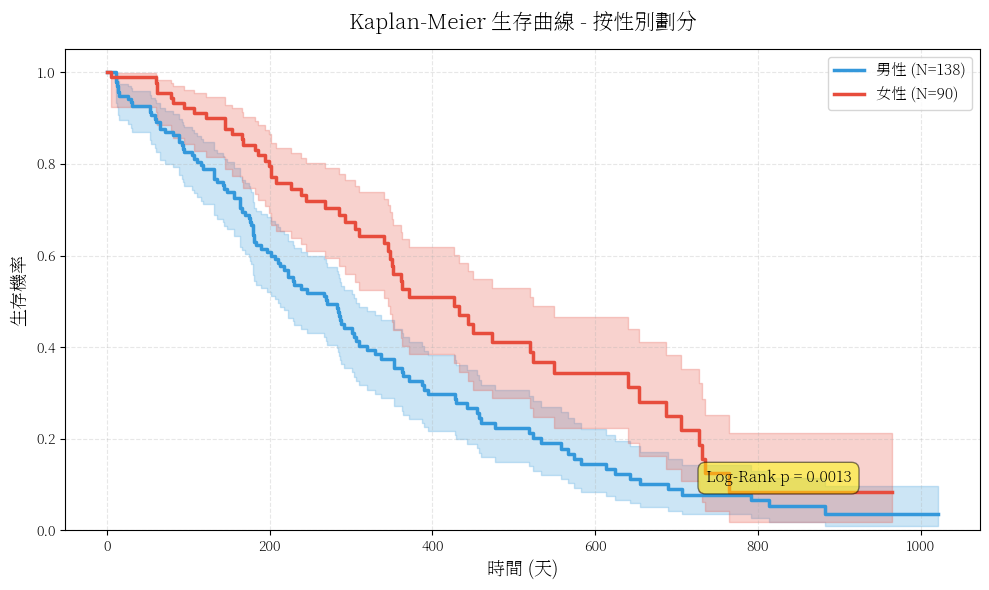

✅ 圖 5 已生成並儲存：5_KM性別分層生存曲線.png

📊 Log-Rank 檢定結果（性別差異）：
   檢定統計量：10.327
   p 值：0.0013
   ✅ 結論：男性與女性的生存曲線有顯著差異（p < 0.05）


In [ ]:
# Install lifelines if not already installed (useful for self-contained cells)
!pip install -q lifelines
!wget -O SourceHanSerifTW-VF.ttf https://github.com/adobe-fonts/source-han-serif/raw/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf --no-verbose

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
import sqlite3
from lifelines import KaplanMeierFitter # Import KaplanMeierFitter
from lifelines.datasets import load_lung # Needed for raw data loading
from lifelines.statistics import logrank_test # For Log-Rank test

# --- Start: Font Setup for Chinese Characters ---
try:
    fm.fontManager.addfont('SourceHanSerifTW-VF.ttf')
    mpl.rc('font', family='Source Han Serif TW VF')
    print("✅ Noto CJK font loaded and set.")
except FileNotFoundError:
    print("⚠️ SourceHanSerifTW-VF.ttf not found. Falling back to default font.")
    mpl.rc('font', family='sans-serif') # Fallback to a generic sans-serif
# --- End: Font Setup ---


# --- Start: Ensure df is correctly loaded and prepared ---

# 1. Load raw data (from `load_data` cell)
print("📥 Re-loading NCCTG Lung Cancer Dataset...")
df_raw = load_lung()

# 2. Re-create database and tables (from `create_db` cell)
db_path = 'lung_cancer.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

print(f"🔄 Re-creating database tables: {db_path}")
cursor.execute("DROP TABLE IF EXISTS patients")
cursor.execute("DROP TABLE IF EXISTS clinical_data")
cursor.execute("DROP TABLE IF EXISTS survival_data")

cursor.execute("""
CREATE TABLE patients (
    patient_id INTEGER PRIMARY KEY,
    age INTEGER,
    sex INTEGER,
    institution INTEGER
)
""")
cursor.execute("""
CREATE TABLE clinical_data (
    patient_id INTEGER,
    ph_ecog REAL,
    ph_karno REAL,
    pat_karno REAL,
    meal_cal REAL,
    wt_loss REAL,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")
cursor.execute("""
CREATE TABLE survival_data (
    patient_id INTEGER,
    time INTEGER,
    status INTEGER,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")

# 3. Insert data into tables (from `insert_data` cell)
df_with_id = df_raw.copy()
df_with_id.insert(0, 'patient_id', range(1, len(df_with_id) + 1))

patients_data = df_with_id[['patient_id', 'age', 'sex', 'inst']]
patients_data = patients_data.rename(columns={'inst': 'institution'})
patients_data.to_sql('patients', conn, if_exists='append', index=False)

clinical_data = df_with_id[[
    'patient_id', 'ph.ecog', 'ph.karno',
    'pat.karno', 'meal.cal', 'wt.loss'
]].copy()
clinical_data.columns = [
    'patient_id', 'ph_ecog', 'ph_karno',
    'pat_karno', 'meal_cal', 'wt_loss'
]
clinical_data.to_sql('clinical_data', conn, if_exists='append', index=False)

survival_data = df_with_id[['patient_id', 'time', 'status']]
survival_data.to_sql('survival_data', conn, if_exists='append', index=False)
conn.commit()

print("✅ Database tables re-created and data inserted.")

# 4. Query the full dataset from the database (from `clean_data` cell)
query_full = """
SELECT
    p.patient_id,
    p.age,
    p.sex,
    p.institution as inst -- Use 'p.institution' here as per the fixed schema
    ,c.ph_ecog,
    c.ph_karno,
    c.pat_karno,
    c.meal_cal,
    c.wt_loss,
    s.time,
    s.status
FROM patients p
INNER JOIN clinical_data c ON p.patient_id = c.patient_id
INNER JOIN survival_data s ON p.patient_id = s.patient_id
"""
df = pd.read_sql_query(query_full, conn)
conn.close() # Close connection after querying

# 5. Apply cleaning (median imputation) (from `clean_data` cell)
df['ph_ecog'] = df['ph_ecog'].fillna(df['ph_ecog'].median())
df['ph_karno'] = df['ph_karno'].fillna(df['ph_karno'].median())
df['pat_karno'] = df['pat_karno'].fillna(df['pat_karno'].median())
df['meal_cal'] = df['meal_cal'].fillna(df['meal_cal'].median())
df['wt_loss'] = df['wt_loss'].fillna(df['wt_loss'].median())

# 6. Re-apply feature engineering steps (from `feature_engineering` cell)
df['性別'] = df['sex'].map({1: '男性', 2: '女性'})
df['event'] = (df['status'] == 1).astype(int)  # 1=死亡, 0=存活/設限
df['事件狀態'] = df['event'].map({1: '死亡', 0: '存活（設限）'})
df['ECOG'] = df['ph_ecog'].apply(
    lambda x: '良好 (0-1)' if x <= 1 else '不良 (2-3)'
)
df['年齡分組'] = df['age'].apply(
    lambda x: '<65 歲' if x < 65 else '≥65 歲'
)
df['Karnofsky'] = df['ph_karno'].apply(
    lambda x: '不良 (<70)' if x < 70 else '良好 (≥70)'
)
df['生存月數'] = (df['time'] / 30.44).round(1)
# --- End: Ensure df is correctly loaded and prepared ---

# 繪製按性別劃分的 Kaplan-Meier 曲線
plt.figure(figsize=(10, 6))

colors = {'男性': '#3498db', '女性': '#e74c3c'}
for sex_label in df['性別'].unique():
    mask = df['性別'] == sex_label
    kmf_sex = KaplanMeierFitter()
    kmf_sex.fit(durations=df[mask]['time'],
                event_observed=df[mask]['event'],
                label=f'{sex_label} (N={mask.sum()})')
    kmf_sex.plot_survival_function(ci_show=True, color=colors[sex_label], linewidth=2.5)

plt.xlabel('時間 (天)', fontsize=13)
plt.ylabel('生存機率', fontsize=13)
plt.title('Kaplan-Meier 生存曲線 - 按性別劃分', fontsize=15, fontweight='bold', pad=15)
plt.grid(alpha=0.3, linestyle='--')
plt.ylim([0, 1.05])
plt.legend(fontsize=11, loc='best')

# 執行 Log-Rank 檢定
male_mask = df['性別'] == '男性'
female_mask = df['性別'] == '女性'

results = logrank_test(
    durations_A=df[male_mask]['time'],
    durations_B=df[female_mask]['time'],
    event_observed_A=df[male_mask]['event'],
    event_observed_B=df[female_mask]['event']
)

# 在圖中新增 Log-Rank p 值註釋
plt.text(0.7, 0.1, f'Log-Rank p = {results.p_value:.4f}',
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

plt.tight_layout()
plt.savefig('5_KM性別分層生存曲線.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 圖 5 已生成並儲存：5_KM性別分層生存曲線.png")

print(f"\n📊 Log-Rank 檢定結果（性別差異）：")
print(f"   檢定統計量：{results.test_statistic:.3f}")
print(f"   p 值：{results.p_value:.4f}")
if results.p_value < 0.05:
    print(f"   ✅ 結論：男性與女性的生存曲線有顯著差異（p < 0.05）")
else:
    print(f"   ❌ 結論：男性與女性的生存曲線無顯著差異（p \u2265 0.05）")

2026-02-22 14:05:53 URL:https://raw.githubusercontent.com/adobe-fonts/source-han-serif/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf [16851180/16851180] -> "SourceHanSerifTW-VF.ttf" [1]
✅ Noto CJK font loaded and set.
📥 Re-loading NCCTG Lung Cancer Dataset...
🔄 Re-creating database tables: lung_cancer.db
✅ Database tables re-created and data inserted.


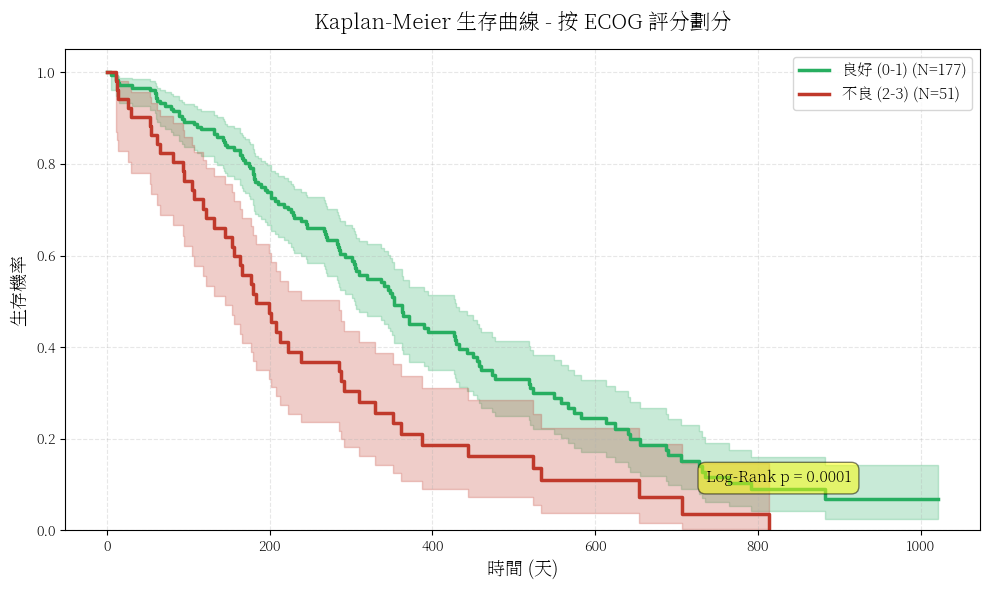

✅ 圖 6 已生成並儲存：6_ECOG分層KM曲線.png

📊 Log-Rank 檢定結果（ECOG 差異）：
   檢定統計量：15.547
   p 值：0.0001
   ✅ 結論：ECOG 良好組與不良組的生存曲線有顯著差異（p < 0.05）


In [ ]:
# Install lifelines if not already installed (useful for self-contained cells)
!pip install -q lifelines
!wget -O SourceHanSerifTW-VF.ttf https://github.com/adobe-fonts/source-han-serif/raw/release/Variable/TTF/Subset/SourceHanSerifTW-VF.ttf --no-verbose

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
import sqlite3
from lifelines import KaplanMeierFitter # Import KaplanMeierFitter
from lifelines.datasets import load_lung # Needed for raw data loading
from lifelines.statistics import logrank_test # For Log-Rank test

# --- Start: Font Setup for Chinese Characters ---
try:
    fm.fontManager.addfont('SourceHanSerifTW-VF.ttf')
    mpl.rc('font', family='Source Han Serif TW VF')
    print("✅ Noto CJK font loaded and set.")
except FileNotFoundError:
    print("⚠️ SourceHanSerifTW-VF.ttf not found. Falling back to default font.")
    mpl.rc('font', family='sans-serif') # Fallback to a generic sans-serif
# --- End: Font Setup ---


# --- Start: Ensure df is correctly loaded and prepared ---

# 1. Load raw data (from `load_data` cell)
print("📥 Re-loading NCCTG Lung Cancer Dataset...")
df_raw = load_lung()

# 2. Re-create database and tables (from `create_db` cell)
db_path = 'lung_cancer.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

print(f"🔄 Re-creating database tables: {db_path}")
cursor.execute("DROP TABLE IF EXISTS patients")
cursor.execute("DROP TABLE IF EXISTS clinical_data")
cursor.execute("DROP TABLE IF EXISTS survival_data")

cursor.execute("""
CREATE TABLE patients (
    patient_id INTEGER PRIMARY KEY,
    age INTEGER,
    sex INTEGER,
    institution INTEGER
)
""")
cursor.execute("""
CREATE TABLE clinical_data (
    patient_id INTEGER,
    ph_ecog REAL,
    ph_karno REAL,
    pat_karno REAL,
    meal_cal REAL,
    wt_loss REAL,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")
cursor.execute("""
CREATE TABLE survival_data (
    patient_id INTEGER,
    time INTEGER,
    status INTEGER,
    FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
)
""")

# 3. Insert data into tables (from `insert_data` cell)
df_with_id = df_raw.copy()
df_with_id.insert(0, 'patient_id', range(1, len(df_with_id) + 1))

patients_data = df_with_id[['patient_id', 'age', 'sex', 'inst']]
patients_data = patients_data.rename(columns={'inst': 'institution'})
patients_data.to_sql('patients', conn, if_exists='append', index=False)

clinical_data = df_with_id[[
    'patient_id', 'ph.ecog', 'ph.karno',
    'pat.karno', 'meal.cal', 'wt.loss'
]].copy()
clinical_data.columns = [
    'patient_id', 'ph_ecog', 'ph_karno',
    'pat_karno', 'meal_cal', 'wt_loss'
]
clinical_data.to_sql('clinical_data', conn, if_exists='append', index=False)

survival_data = df_with_id[['patient_id', 'time', 'status']]
survival_data.to_sql('survival_data', conn, if_exists='append', index=False)
conn.commit()

print("✅ Database tables re-created and data inserted.")

# 4. Query the full dataset from the database (from `clean_data` cell)
query_full = """
SELECT
    p.patient_id,
    p.age,
    p.sex,
    p.institution as inst -- Use 'p.institution' here as per the fixed schema
    ,c.ph_ecog,
    c.ph_karno,
    c.pat_karno,
    c.meal_cal,
    c.wt_loss,
    s.time,
    s.status
FROM patients p
INNER JOIN clinical_data c ON p.patient_id = c.patient_id
INNER JOIN survival_data s ON p.patient_id = s.patient_id
"""
df = pd.read_sql_query(query_full, conn)
conn.close() # Close connection after querying

# 5. Apply cleaning (median imputation) (from `clean_data` cell)
df['ph_ecog'] = df['ph_ecog'].fillna(df['ph_ecog'].median())
df['ph_karno'] = df['ph_karno'].fillna(df['ph_karno'].median())
df['pat_karno'] = df['pat_karno'].fillna(df['pat_karno'].median())
df['meal_cal'] = df['meal_cal'].fillna(df['meal_cal'].median())
df['wt_loss'] = df['wt_loss'].fillna(df['wt_loss'].median())

# 6. Re-apply feature engineering steps (from `feature_engineering` cell)
df['性別'] = df['sex'].map({1: '男性', 2: '女性'})
df['event'] = (df['status'] == 1).astype(int)  # 1=死亡, 0=存活/設限
df['事件狀態'] = df['event'].map({1: '死亡', 0: '存活（設限）'})
df['ECOG'] = df['ph_ecog'].apply(
    lambda x: '良好 (0-1)' if x <= 1 else '不良 (2-3)'
)
df['年齡分組'] = df['age'].apply(
    lambda x: '<65 歲' if x < 65 else '≥65 歲'
)
df['Karnofsky'] = df['ph_karno'].apply(
    lambda x: '不良 (<70)' if x < 70 else '良好 (≥70)'
)
df['生存月數'] = (df['time'] / 30.44).round(1)
# --- End: Ensure df is correctly loaded and prepared ---

# 繪製按 ECOG 劃分的 Kaplan-Meier 曲線
plt.figure(figsize=(10, 6))

colors_ecog = {'良好 (0-1)': '#27ae60', '不良 (2-3)': '#c0392b'}
for ecog_group in df['ECOG'].unique():
    mask = df['ECOG'] == ecog_group
    kmf_ecog = KaplanMeierFitter()
    kmf_ecog.fit(durations=df[mask]['time'],
                 event_observed=df[mask]['event'],
                 label=f'{ecog_group} (N={mask.sum()})')
    kmf_ecog.plot_survival_function(ci_show=True, color=colors_ecog[ecog_group], linewidth=2.5)

plt.xlabel('時間 (天)', fontsize=13)
plt.ylabel('生存機率', fontsize=13)
plt.title('Kaplan-Meier 生存曲線 - 按 ECOG 評分劃分', fontsize=15, fontweight='bold', pad=15)
plt.grid(alpha=0.3, linestyle='--')
plt.ylim([0, 1.05])
plt.legend(fontsize=11, loc='best')

# 執行 Log-Rank 檢定
good_mask = df['ECOG'] == '良好 (0-1)'
poor_mask = df['ECOG'] == '不良 (2-3)'

results_ecog = logrank_test(
    durations_A=df[good_mask]['time'],
    durations_B=df[poor_mask]['time'],
    event_observed_A=df[good_mask]['event'],
    event_observed_B=df[poor_mask]['event']
)

# 在圖中新增 Log-Rank p 值註釋
plt.text(0.7, 0.1, f'Log-Rank p = {results_ecog.p_value:.4f}',
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

plt.tight_layout()
plt.savefig('6_ECOG分層KM曲線.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 圖 6 已生成並儲存：6_ECOG分層KM曲線.png")

print(f"\n📊 Log-Rank 檢定結果（ECOG 差異）：")
print(f"   檢定統計量：{results_ecog.test_statistic:.3f}")
print(f"   p 值：{results_ecog.p_value:.4f}")
if results_ecog.p_value < 0.05:
    print(f"   ✅ 結論：ECOG 良好組與不良組的生存曲線有顯著差異（p < 0.05）")
else:
    print(f"   ❌ 結論：ECOG 良好組與不良組的生存曲線無顯著差異（p \u2265 0.05）")